# Machine learning for parameter optimization in polymer simulation

# Make examples for presentation

# Testing gaussian optimization

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import readdy
import math
import scipy
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
import time
import scipy.integrate as integrate
print(readdy.__version__)
from scipy.spatial.transform import Rotation as Rot
from sklearn.cluster import DBSCAN
from sklearn import metrics
from collections import Counter

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
#from tensorflow.keras import datasets, layers, models, Model, Input
import pandas as pd

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel

from scipy.stats import norm

2.0.12-1


# Functions for Gaussian optimization from Pascal Friederich's lecture

In [2]:
def kernel(a, b):
    sqdist = np.sum(a**2, 1).reshape(-1, 1)         + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return(np.exp(-0.5*sqdist))


class gp:
    def __init__(self, kernel):
        self.kernel = kernel
        
    def train(self, X, f):
        self.X = X
        self.f = f
        self.K = self.kernel(self.X, self.X)
        self.Kinv = np.linalg.inv(self.K + 1e-6*np.eye((len(X))))
        
    def predict(self, X_pred):
        Ks = self.kernel(self.X, X_pred)
        Kss = self.kernel(X_pred, X_pred)
        mu_s = Ks.T.dot(self.Kinv).dot(self.f)
        cov_s = Kss - Ks.T.dot(self.Kinv).dot(Ks)
        mu = mu_s.ravel()
        uncertainty = np.sqrt(np.diag(cov_s))
        return(mu, uncertainty)


# a made up function for ground truth.
# should be replaced with an actual (computer) experiment
def ground_truth(x):
    f = 1.6*np.exp(-1.2*(x - 1.3)**2) + 2.4*np.exp(-0.9*(x - 3.7)**2)
    return(f)


def ground_truth(x):
    f = 2*np.exp(-2*(x - 1.5)**2) + 1*np.exp(-1*(x -4 )**2) #+ 0.5*np.exp(-0.5*(x -3 )**2)
    return(f)

# Acquisition function
def acquisition_function_upper_confidence_bound(mu, uncertainty):
    ac = mu + uncertainty
    return(ac)

# Acquisition function
def acquisition_function_upper_confidence_bound_mod(mu, uncertainty,a,b):
    ac = mu*a + uncertainty*b
    return(ac)

#https://medium.com/@okanyenigun/step-by-step-guide-to-bayesian-optimization-a-python-based-approach-3558985c6818

def acquisition_function_expected_improvement(mu, uncertainty, best_f):
    y_pred, y_std = mu, uncertainty
    z = (y_pred - best_f) / y_std
    ei = (y_pred - best_f) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

def acquisition_function_probability_of_improvement(mu, uncertainty, best_f):
    y_pred, y_std = mu, uncertainty
    z = (y_pred - best_f) / y_std
    pi = norm.cdf(z)
    return pi

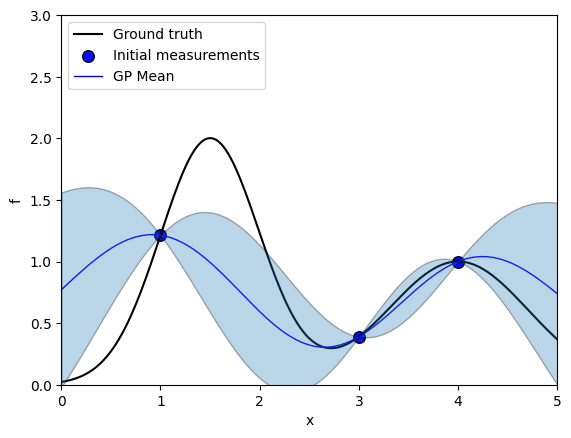

In [3]:
# some initial values
n = 200
x = np.linspace(0, 5, n).reshape(-1, 1)
f = ground_truth(x)
data_x = np.array([1, 3, 4])
data_f = ground_truth(data_x)


# fitting the initial GP model
gp_model = gp(kernel)
gp_model.train(data_x.reshape(-1, 1), data_f.reshape(-1, 1))
mu, uncertainty = gp_model.predict(x)


# plotting the data and the GP model
plt.figure()
plt.plot(x, f, "k-", label = "Ground truth")
plt.scatter(data_x, data_f, marker = "o", s = 70.0, edgecolor="k", facecolor="b", alpha = 0.95, label = "Initial measurements")
plt.plot(x.ravel(), mu, label = 'GP Mean', linewidth = 1, color = "b")
plt.fill_between(x.ravel(), mu + uncertainty, mu - uncertainty, alpha = 0.3, edgecolor = "k", zorder = 2)
plt.xlabel("x")
plt.ylabel("f")
plt.xlim([0, 5])
plt.ylim([0, 3])
plt.legend(loc="upper left")
#plt.savefig("gp.png", dpi=200)

In [4]:
num_steps = 10
for i in range(num_steps):
    ac = acquisition_function_upper_confidence_bound(mu, uncertainty)
    x_next = x[np.argmax(ac)]
    f_next = ground_truth(x_next)
    print("Iteration {}: New point: {} {}".format(i + 1, x_next, f_next))
    data_x = np.append(data_x, x_next)
    data_f = np.append(data_f, f_next)
    gp_model = gp(kernel)
    gp_model.train(data_x.reshape(-1, 1), data_f.reshape(-1, 1))
    mu, uncertainty = gp_model.predict(x)

Iteration 1: New point: [0.27638191] [0.10012601]
Iteration 2: New point: [1.58291457] [1.97559104]
Iteration 3: New point: [1.75879397] [1.75585469]
Iteration 4: New point: [1.48241206] [2.00053043]
Iteration 5: New point: [1.50753769] [2.00177723]
Iteration 6: New point: [1.50753769] [2.00177723]
Iteration 7: New point: [1.50753769] [2.00177723]
Iteration 8: New point: [1.50753769] [2.00177723]
Iteration 9: New point: [1.50753769] [2.00177723]
Iteration 10: New point: [1.50753769] [2.00177723]


Iteration 1
New data point: [3.04020101] [0.41543538]
Iteration 2
New data point: [4.92462312] [0.42531385]
Iteration 3
New data point: [1.50753769] [2.00177723]
Iteration 4
New data point: [1.45728643] [1.99427188]
Iteration 5
New data point: [1.50753769] [2.00177723]


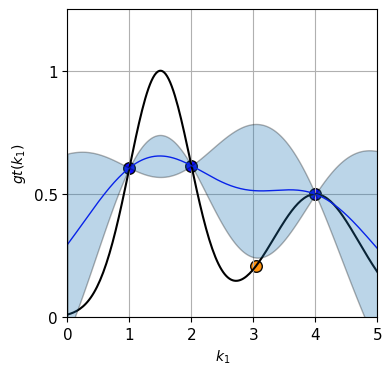

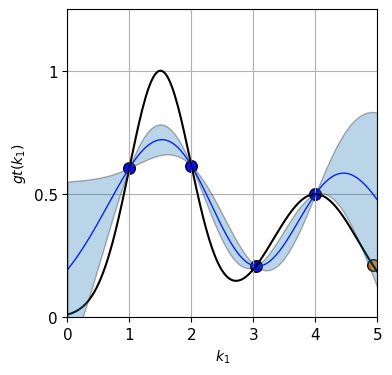

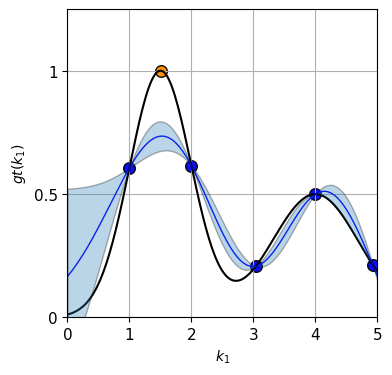

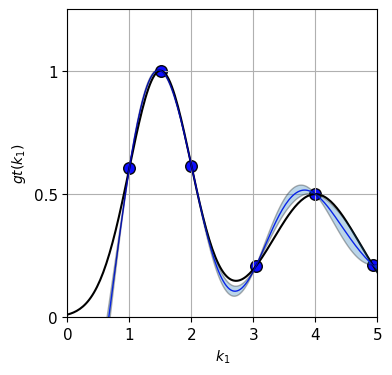

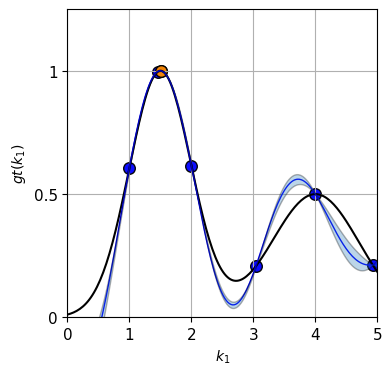

In [17]:
# some initial values
n = 200
x = np.linspace(0, 5, n).reshape(-1, 1)
f = ground_truth(x)
data_x = np.array([1,2,4])
data_f = ground_truth(data_x)

for i in range(5):
    print("Iteration",i+1)
    

    # fitting the initial GP model
    gp_model = gp(kernel)
    gp_model.train(data_x.reshape(-1, 1), data_f.reshape(-1, 1))
    mu, uncertainty = gp_model.predict(x)


    # plotting the data and the GP model
    plt.figure(figsize=(4,4))
    plt.plot(x, f, "k-", label = "200 simulations")
    plt.scatter(data_x, data_f, marker = "o", s = 70.0, edgecolor="k", facecolor="b", alpha = 0.95, label = "Trial simulations")
    plt.plot(x.ravel(), mu, label = 'Gaussian process model', linewidth = 1, color = "b")
    plt.fill_between(x.ravel(), mu + uncertainty, mu - uncertainty, alpha = 0.3, edgecolor = "k", zorder = 2)
    plt.ylabel(r"$gt(k_1)$")
    plt.xlabel(r"$k_1$")
    plt.xlim([0, 5])
    plt.ylim([0, 2.5])
    plt.yticks([0,1,2],[0,0.5,1],fontsize=11)
    plt.xticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=11)
    
    plt.grid()
    #plt.show()
    name_1="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/demonstration_tests/gt_example_no_gt_"+str(i)+".svg"
    
    #update model with new data point
    ac = acquisition_function_upper_confidence_bound(mu, uncertainty)
    x_next = x[np.argmax(ac)]
    f_next = ground_truth(x_next)
    print("New data point:",x_next,f_next)
    #append new data and update model fit
    data_x = np.append(data_x, x_next)
    data_f = np.append(data_f, f_next)
    if i!=3:
        plt.scatter(x_next, f_next, marker = "o", s = 70.0, edgecolor="k", facecolor="darkorange", alpha = 0.95, label = "Next simulation")
    
    
    
    #plt.legend(loc="upper left",prop={'size': 11})
    
    plt.savefig(name_1,format="svg",bbox_inches="tight")

Iteration 1
New data point: [3.04020101] [0.41543538]
Iteration 2
New data point: [4.92462312] [0.42531385]
Iteration 3
New data point: [1.50753769] [2.00177723]
Iteration 4
New data point: [1.45728643] [1.99427188]
Iteration 5
New data point: [1.50753769] [2.00177723]


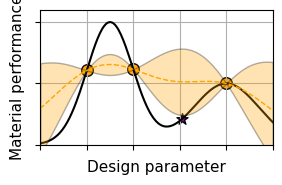

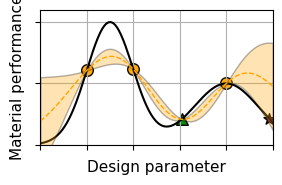

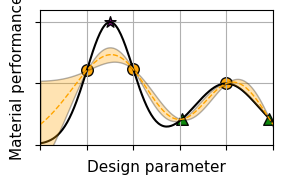

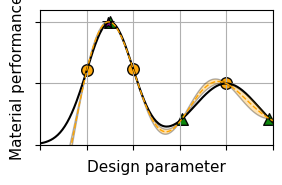

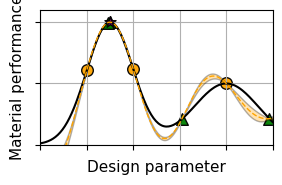

In [8]:
# some initial values
n = 200
x = np.linspace(0, 5, n).reshape(-1, 1)
f = ground_truth(x)
data_x = np.array([1,2,4])
data_f = ground_truth(data_x)

for i in range(5):
    print("Iteration",i+1)
    

    # fitting the initial GP model
    gp_model = gp(kernel)
    gp_model.train(data_x.reshape(-1, 1), data_f.reshape(-1, 1))
    mu, uncertainty = gp_model.predict(x)


    # plotting the data and the GP model
    plt.figure(figsize=(3,1.75))
    plt.plot(x, f, "k-", label = "Unknown ground truth")
    plt.scatter(data_x[:3], data_f[:3], marker = "o", s = 70.0, edgecolor="k", facecolor="orange", alpha = 0.95, label = "Designs initially screened")
    plt.scatter(data_x[3:], data_f[3:], marker = "^", s = 70.0, edgecolor="k", facecolor="green", alpha = 0.95, label = "Designs iteratively added")

    plt.errorbar(x.ravel(), mu, label = 'Model prediction +/- uncertainty', linewidth = 1, color = "orange",fmt="--")
    plt.fill_between(x.ravel(), mu + uncertainty, mu - uncertainty, alpha = 0.3, color = "orange", edgecolor = "k", zorder = 2)
    plt.ylabel("Material performance",fontsize=11)
    plt.xlabel("Design parameter",fontsize=11)
    plt.xlim([0, 5])
    plt.ylim([0, 2.2])
    plt.yticks([0,1,2],[],fontsize=11)
    plt.xticks([0,1,2,3,4,5],[],fontsize=11)
    
    plt.grid()
    #plt.show()
    name_1="ML_parameter_opt_1/demonstration_tests/gt_example_5_"+str(i)+".pdf"
    
    #update model with new data point
    ac = acquisition_function_upper_confidence_bound(mu, uncertainty)
    x_next = x[np.argmax(ac)]
    f_next = ground_truth(x_next)
    print("New data point:",x_next,f_next)
    #append new data and update model fit
    data_x = np.append(data_x, x_next)
    data_f = np.append(data_f, f_next)
    #if i!=3:
    plt.scatter(x_next, f_next, marker = "*", s = 70.0, edgecolor="k", facecolor="purple", alpha = 0.95, label = "Next design")
    
    
    
    #plt.legend(loc="upper left",prop={'family': 'Arial','size': 11})
    
    #plt.savefig(name_1,format="pdf",bbox_inches="tight")

In [9]:


def gaussian_opt(index_target_k,num_iterations,simulated_k, results_simulated_k, indices_initial_k,a=1,b=1):
    #run gaussian opt. for every target in index_target_k
    
    for i in range(len(index_target_k)):
        #get ground truth for indexed k
        target_result=results_simulated_k[index_target_k[i]]
        #calculate the difference between the result of target k (mean, std or full distribution) and the results from all k values
        
        deviation=[]
        for j in range(len(results_simulated_k)):
            deviation.append(np.sum(np.abs(target_result-results_simulated_k[j])) ) #k values, zero for target k
        deviation=np.asarray(deviation)
        #get function to optimize
        ground_truth_1=1/(deviation+1)
        #ground_truth_1=gaussian_filter(ground_truth_1,sigma=1)
        #gd_scaler=MinMaxScaler(feature_range=(0, 1))
        #ground_truth_1=gd_scaler.fit_transform(ground_truth_1.reshape(-1, 1)).flatten() 
        '''plt.figure()
        plt.errorbar(np.arange(0,len(ground_truth)),ground_truth)
        plt.xlabel("k")
        plt.ylabel("f")
        plt.grid()
        plt.show()'''
        
        #get x values for prediction after fitting
        #n = 200
        x = simulated_k.reshape(-1, 1)  #np.linspace(0, 1, n).reshape(-1, 1)
        
        #append initial training data
        data_x=[]
        data_f=[]
        data_x_init=[]
        data_f_init=[]
        for s in indices_initial_k:
            data_x.append(simulated_k[s])
            data_f.append(ground_truth_1[s])
            data_x_init.append(simulated_k[s])
            data_f_init.append(ground_truth_1[s])
        data_x=np.asarray(data_x)
        data_f=np.asarray(data_f)
        conver1=False
        gp_model = gp(kernel)
        for m in range(num_iterations):
            print("Iteration",m+1)
            if m>1 and np.round(f_next,5)>=1:
                conver1=True    
            # fitting the initial GP model
            #gp_model = gp(kernel)
            gp_model.train(data_x.reshape(-1, 1), data_f.reshape(-1, 1))
            mu, uncertainty = gp_model.predict(x)


            # plotting the data and the GP model
            plt.figure(dpi=300)
            plt.plot(x, ground_truth_1, "k-", label = "Ground truth")
            plt.scatter(data_x, data_f, marker = "o", s = 70.0, edgecolor="k", facecolor="r", alpha = 0.95, label = "New measurements")
            plt.scatter(data_x_init, data_f_init, marker = "o", s = 70.0, edgecolor="k", facecolor="grey", alpha = 0.95, label = "Initial measurements")
  
            plt.plot(x.ravel(), mu, label = 'GP Mean', linewidth = 1, color = "b")
            plt.fill_between(x.ravel(), mu + uncertainty, mu - uncertainty, alpha = 0.3, edgecolor = "k", zorder = 0)
            plt.xlabel("x")
            plt.ylabel("f")
            #plt.xlim([0, 5])
            #plt.ylim([0.95, 1.04])
            
            if conver1==True:
                plt.scatter(x_next, f_next, marker = "x", s = 70.0, color="black", alpha = 0.95, label = "Optimized value")
                plt.legend(loc="lower left")  
                plt.grid()
                plt.show()
                print("Convergence in step",m+1)
                break
            #update model with new data point
            #upper conf bound
            #ac = acquisition_function_upper_confidence_bound_mod(mu, uncertainty,a,b)
            
            #expected improvement
            ac=acquisition_function_expected_improvement(mu, uncertainty,best_f=np.max(ground_truth_1))
            
            # prob of improvement
            #ac=acquisition_function_probability_of_improvement(mu, uncertainty,best_f=np.max(ground_truth_1))
            
            x_next = x[np.argmax(ac)]
            f_next = ground_truth_1[np.argmax(ac)]
            print("New data point:",x_next,f_next)
            #append new data and update model fit
            data_x = np.append(data_x, x_next)
            data_f = np.append(data_f, f_next)
            
            plt.scatter(x_next, f_next, marker = "o", s = 70.0, edgecolor="k", facecolor="darkorange", alpha = 0.95, label = "Next measurement")
            plt.legend(loc="lower left", prop={'size': 11})
            plt.ylabel("f",fontsize=11)
            plt.xlabel("x",fontsize=11)
            tex_1=plt.xticks(fontsize=11)
            tex_2=plt.yticks(fontsize=11)
            plt.grid()
            plt.show()
            
            #if conver1==True:
             #   print("Convergence in step",m+1)
             #   break
        
    

# Gaussian optimization for angle distribution of y-motif

# Functions based on lecture

In [10]:
#get names of particles for vectors for angles, first entry: name of particle further away from centre
arms_names_1=[["y_arm_a_1","y_base_arm_a_1"],["y_arm_b_1","y_base_arm_b_1"],["y_arm_c_1","y_base_arm_c_1"]]

def angle_1(v1,v2):
    v1_n=v1/np.linalg.norm(v1)
    v2_n=v2/np.linalg.norm(v2)
    return np.arccos(np.clip(np.dot(v1_n,v2_n),-1,1))

def conf_angles_r_1(pos,types,traj,arms_names):
    angles_arms=[]
    
    #pos of particles are in same order for each time step
    #get pos in array from first time step
    arms_names_pos=[]
    for g in range(len(arms_names)):
        arms_names_pos_e=[]
        arm_name_sel=arms_names[g][0]
        base_name_sel=arms_names[g][1]
        for s in range(len(pos[0])):
            if traj.species_name(types[0][s])==arm_name_sel:
                arms_names_pos_e.append(s)
                
        for t in range(len(pos[0])):
             if traj.species_name(types[0][t])==base_name_sel:
                arms_names_pos_e.append(t) 
                
        arms_names_pos.append(arms_names_pos_e) 
    #print(arms_names_pos)
    #get all vectors for time point i
    
    for i in range(len(pos)):#iterate time points
        
        #vectors at given time: 
        list_of_vectors=[] 
        for n in range(len(arms_names_pos)):#iterate arms
            pos_1=arms_names_pos[n][0]
            pos_2=arms_names_pos[n][1]
            
            list_of_vectors.append(pos[i][pos_1]-pos[i][pos_2])
            
        #angles at given time:   
        angles_arms_t=[]
        for z in range(len(list_of_vectors)):
            ind1=z
            ind2=(z+1)%len(list_of_vectors) #e.g. 0-1, 1-2, 2-0
            #print(ind1,ind2)
            angles_arms_t.append(angle_1(list_of_vectors[ind1],list_of_vectors[ind2])) 
            
        angles_arms.append(angles_arms_t)
    return np.asarray(angles_arms)

def get_training_angle_distr(folder,name_add,arms_names,t_skip=300,t_lim=None,t_step=1):
    angle_distribution_all=[]
    mean_all=[]
    std_all=[]
    fig=plt.figure(figsize=(4,4))
    for i in range(len(name_add)):
        
        #load trajectory
        input_name=folder+"nanomotif_params_1_"+str(name_add[i])+".h5"
        
        traj=readdy.Trajectory(input_name)

        times,types,ids,part_positions=traj.read_observable_particles()
        
        #calculate angles
        angles_arms_all_t_1=conf_angles_r_1(pos=part_positions[t_skip:t_lim:t_step],types=types[t_skip:t_lim:t_step],traj=traj,arms_names=arms_names)

        angles_arms_1=angles_arms_all_t_1  #[t_skip:40000]

        angles_arms_1f=angles_arms_1.flatten()
        
        #get angle distribution
        
        plt.xlabel("Angle [deg]")
        plt.ylabel("Normalized frequency")
        angles_test_hist=plt.hist(angles_arms_1f*180/np.pi,bins=np.arange(0,190,10),density=True, histtype='step')
        angle_distribution_all.append(angles_test_hist[0])
        
        #get mean, std
        mean_all.append(np.mean(angles_arms_1f*180/np.pi))
        
        std_all.append(np.std(angles_arms_1f*180/np.pi) )

       
    return np.asarray(angle_distribution_all), np.asarray(mean_all), np.asarray(std_all)



In [8]:
#load input k values
k_angle_input_1=np.loadtxt("ML_parameter_opt_1/test_runs_3/k_angle_input_1.txt")
print(k_angle_input_1)

scaler_1=MinMaxScaler(feature_range=(0, 5))
k_angle_input_1_rescale= scaler_1.fit_transform(np.asarray([k_angle_input_1*10**20]).reshape(-1, 1)).flatten()    #k_angle_input_1*10**20
print(k_angle_input_1_rescale)

[2.00000000e-22 2.21818182e-21 4.23636364e-21 6.25454545e-21
 8.27272727e-21 1.02909091e-20 1.23090909e-20 1.43272727e-20
 1.63454545e-20 1.83636364e-20 2.03818182e-20 2.24000000e-20
 2.44181818e-20 2.64363636e-20 2.84545455e-20 3.04727273e-20
 3.24909091e-20 3.45090909e-20 3.65272727e-20 3.85454545e-20
 4.05636364e-20 4.25818182e-20 4.46000000e-20 4.66181818e-20
 4.86363636e-20 5.06545455e-20 5.26727273e-20 5.46909091e-20
 5.67090909e-20 5.87272727e-20 6.07454545e-20 6.27636364e-20
 6.47818182e-20 6.68000000e-20 6.88181818e-20 7.08363636e-20
 7.28545455e-20 7.48727273e-20 7.68909091e-20 7.89090909e-20
 8.09272727e-20 8.29454545e-20 8.49636364e-20 8.69818182e-20
 8.90000000e-20 9.10181818e-20 9.30363636e-20 9.50545455e-20
 9.70727273e-20 9.90909091e-20 1.01109091e-19 1.03127273e-19
 1.05145455e-19 1.07163636e-19 1.09181818e-19 1.11200000e-19
 1.13218182e-19 1.15236364e-19 1.17254545e-19 1.19272727e-19
 1.21290909e-19 1.23309091e-19 1.25327273e-19 1.27345455e-19
 1.29363636e-19 1.313818

In [17]:
k_angle_input_1_rescale[90]

4.545454545454546

CPU times: user 3min 11s, sys: 2.25 s, total: 3min 13s
Wall time: 3min 18s


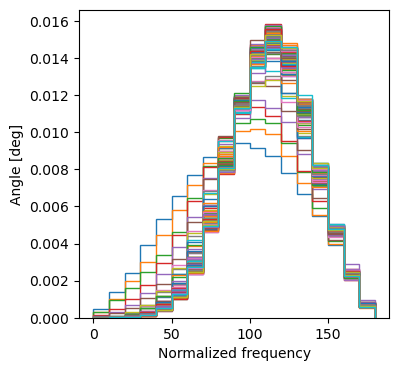

In [9]:
%%time
name_add_list=np.arange(0,100)
angle_distribution_all, mean_all, std_all=get_training_angle_distr(folder="ML_parameter_opt_1/test_runs_3/",name_add=name_add_list,arms_names=arms_names_1,t_skip=3000,t_lim=None,t_step=1)

In [8]:
#convert mean and std to format for input
scaler_2=MinMaxScaler(feature_range=(0, 1))
scaler_3=MinMaxScaler(feature_range=(0, 1))
mean_all_rescale= scaler_2.fit_transform(mean_all.reshape(-1, 1)).flatten()   
std_all_rescale= scaler_3.fit_transform(std_all.reshape(-1, 1)).flatten() 

mean_std_all=[]
for i in range(len(mean_all_rescale)):
    mean_std_all.append([mean_all_rescale[i],std_all_rescale[i]])
mean_std_all=np.asarray(mean_std_all)

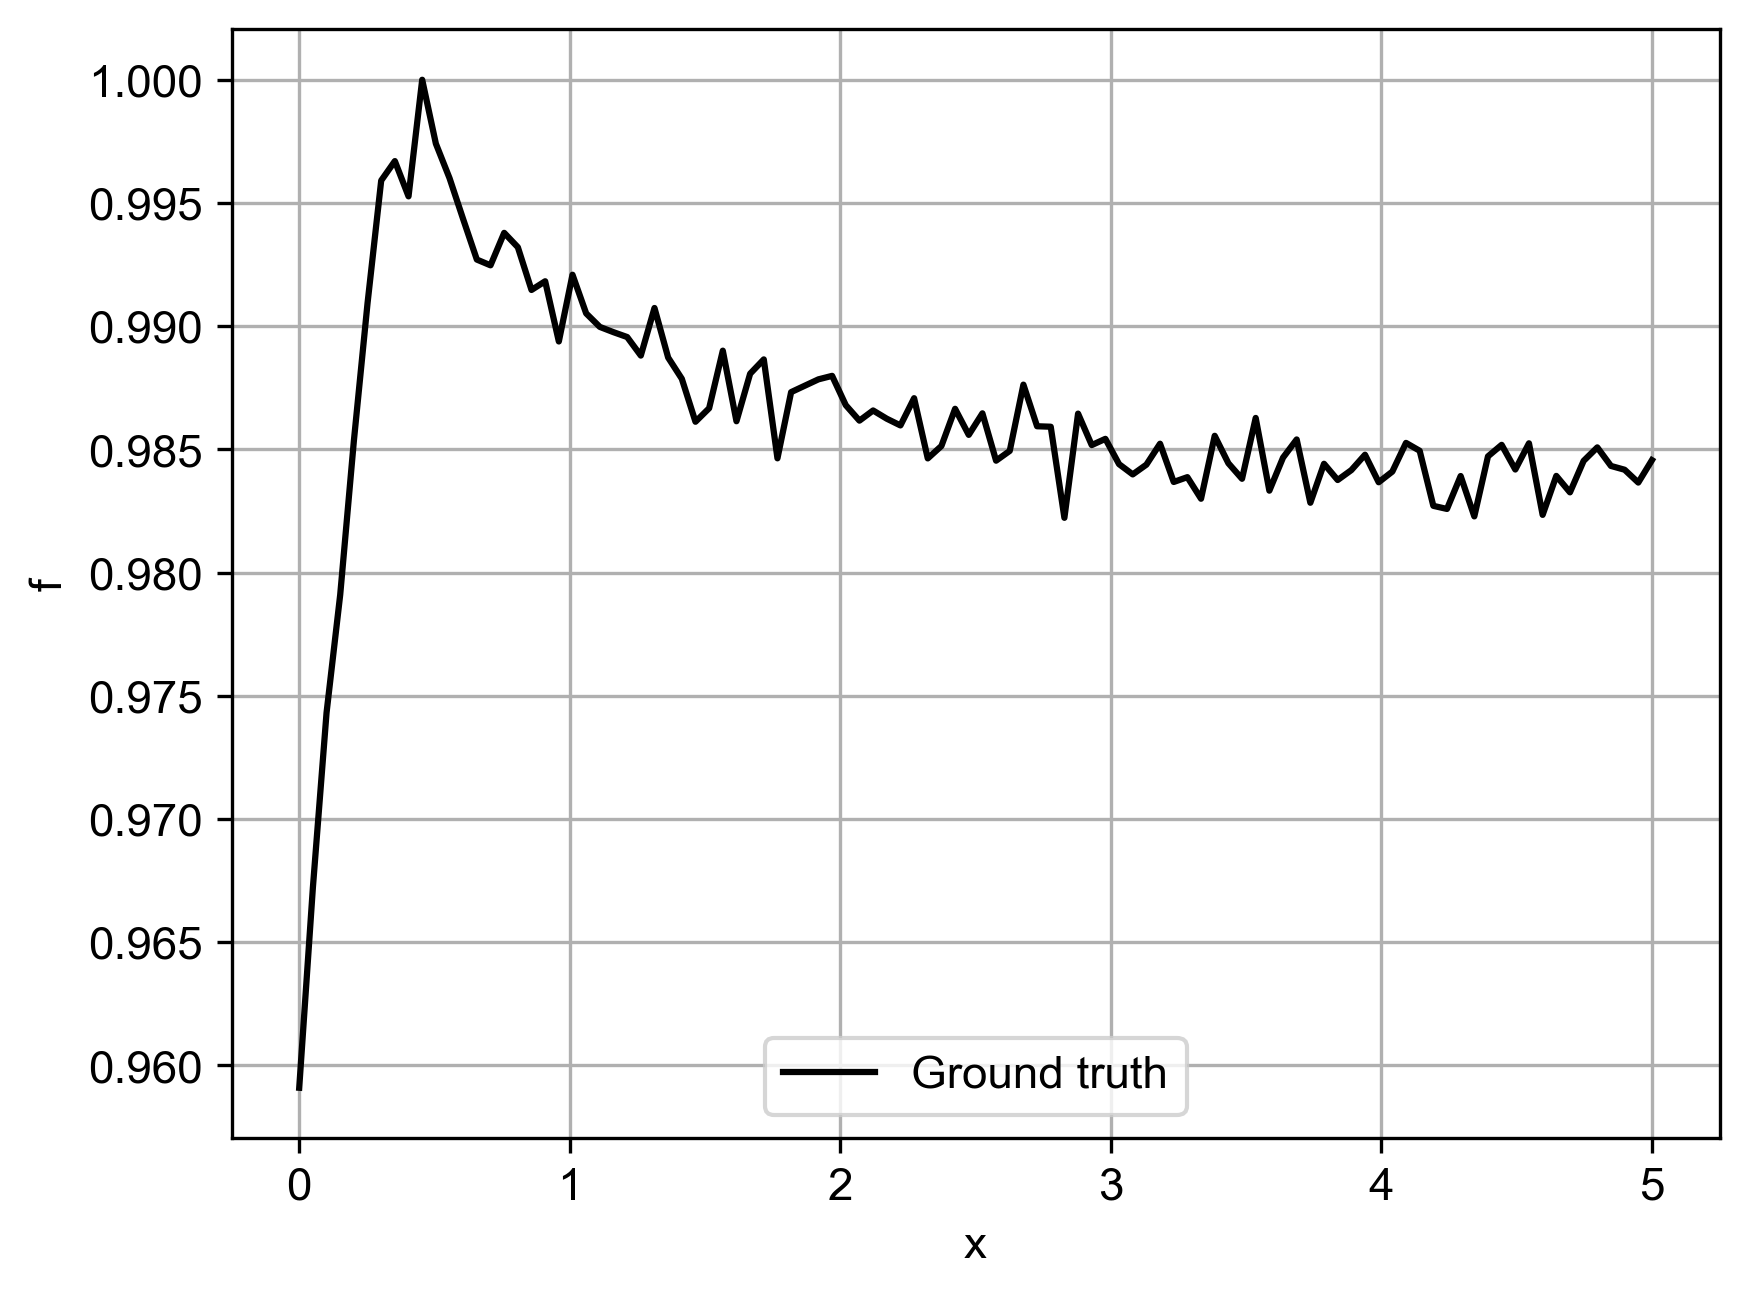

In [19]:
#get ground truth for indexed k
results_simulated_k=angle_distribution_all
target_result=results_simulated_k[9]
#calculate the difference between the result of target k (mean, std or full distribution) and the results from all k values

deviation=[]
for j in range(len(results_simulated_k)):
    deviation.append(np.sum(np.abs(target_result-results_simulated_k[j])) ) #k values, zero for target k
deviation=np.asarray(deviation)
#get function to optimize
ground_truth_1=1/(deviation+1)
x = k_angle_input_1_rescale.reshape(-1, 1)

plt.figure(dpi=300)
plt.plot(x, ground_truth_1, "k-", label = "Ground truth")
#plt.scatter(data_x, data_f, marker = "o", s = 70.0, edgecolor="k", facecolor="r", alpha = 0.95, label = "New measurements")
#plt.scatter(data_x_init, data_f_init, marker = "o", s = 70.0, edgecolor="k", facecolor="b", alpha = 0.95, label = "Initial measurements")

#plt.plot(x.ravel(), mu, label = 'GP Mean', linewidth = 1, color = "b")
#plt.fill_between(x.ravel(), mu + uncertainty, mu - uncertainty, alpha = 0.3, edgecolor = "k", zorder = 0)
plt.ylabel("f",fontsize=11)
plt.xlabel("x",fontsize=11)
tex_1=plt.xticks(fontsize=11)
tex_2=plt.yticks(fontsize=11)
plt.grid()
plt.legend(loc="lower center", prop={'family': 'Arial','size': 11})

In [11]:


def gaussian_opt(index_target_k,num_iterations,simulated_k, results_simulated_k, indices_initial_k,a=1,b=1):
    #run gaussian opt. for every target in index_target_k
    
    for i in range(len(index_target_k)):
        #get ground truth for indexed k
        target_result=results_simulated_k[index_target_k[i]]
        #calculate the difference between the result of target k (mean, std or full distribution) and the results from all k values
        
        deviation=[]
        for j in range(len(results_simulated_k)):
            deviation.append(np.sum(np.abs(target_result-results_simulated_k[j])) ) #k values, zero for target k
        deviation=np.asarray(deviation)
        #get function to optimize
        ground_truth_1=1/(deviation+1)
        #ground_truth_1=gaussian_filter(ground_truth_1,sigma=1)
        #gd_scaler=MinMaxScaler(feature_range=(0, 1))
        #ground_truth_1=gd_scaler.fit_transform(ground_truth_1.reshape(-1, 1)).flatten() 
        '''plt.figure()
        plt.errorbar(np.arange(0,len(ground_truth)),ground_truth)
        plt.xlabel("k")
        plt.ylabel("f")
        plt.grid()
        plt.show()'''
        
        #get x values for prediction after fitting
        #n = 200
        x = simulated_k.reshape(-1, 1)  #np.linspace(0, 1, n).reshape(-1, 1)
        
        #append initial training data
        data_x=[]
        data_f=[]
        data_x_init=[]
        data_f_init=[]
        for s in indices_initial_k:
            data_x.append(simulated_k[s])
            data_f.append(ground_truth_1[s])
            data_x_init.append(simulated_k[s])
            data_f_init.append(ground_truth_1[s])
        data_x=np.asarray(data_x)
        data_f=np.asarray(data_f)
        conver1=False
        gp_model = gp(kernel)
        for m in range(num_iterations):
            print("Iteration",m+1)
            if m>1 and np.round(f_next,5)>=1:
                conver1=True    
            # fitting the initial GP model
            #gp_model = gp(kernel)
            gp_model.train(data_x.reshape(-1, 1), data_f.reshape(-1, 1))
            mu, uncertainty = gp_model.predict(x)


            # plotting the data and the GP model
            plt.figure(dpi=300)
            plt.plot(x, ground_truth_1, "k-", label = "Ground truth")
            plt.scatter(data_x, data_f, marker = "o", s = 70.0, edgecolor="k", facecolor="r", alpha = 0.95, label = "New measurements")
            plt.scatter(data_x_init, data_f_init, marker = "o", s = 70.0, edgecolor="k", facecolor="grey", alpha = 0.95, label = "Initial measurements")
  
            plt.plot(x.ravel(), mu, label = 'GP Mean', linewidth = 1, color = "b")
            plt.fill_between(x.ravel(), mu + uncertainty, mu - uncertainty, alpha = 0.3, edgecolor = "k", zorder = 0)
            plt.xlabel("x")
            plt.ylabel("f")
            #plt.xlim([0, 5])
            #plt.ylim([0.95, 1.04])
            
            if conver1==True:
                plt.scatter(x_next, f_next, marker = "x", s = 70.0, color="black", alpha = 0.95, label = "Optimized value")
                plt.legend(loc="lower left")  
                plt.grid()
                plt.show()
                print("Convergence in step",m+1)
                break
            #update model with new data point
            #upper conf bound
            #ac = acquisition_function_upper_confidence_bound_mod(mu, uncertainty,a,b)
            
            #expected improvement
            ac=acquisition_function_expected_improvement(mu, uncertainty,best_f=np.max(ground_truth_1))
            
            # prob of improvement
            #ac=acquisition_function_probability_of_improvement(mu, uncertainty,best_f=np.max(ground_truth_1))
            
            x_next = x[np.argmax(ac)]
            f_next = ground_truth_1[np.argmax(ac)]
            print("New data point:",x_next,f_next)
            #append new data and update model fit
            data_x = np.append(data_x, x_next)
            data_f = np.append(data_f, f_next)
            
            plt.scatter(x_next, f_next, marker = "o", s = 70.0, edgecolor="k", facecolor="darkorange", alpha = 0.95, label = "Next measurement")
            plt.legend(loc="lower left", prop={'family': 'Arial','size': 11})
            plt.ylabel("f",fontsize=11)
            plt.xlabel("x",fontsize=11)
            tex_1=plt.xticks(fontsize=11)
            tex_2=plt.yticks(fontsize=11)
            plt.grid()
            plt.show()
            
            #if conver1==True:
             #   print("Convergence in step",m+1)
             #   break
        
    

Iteration 1
New data point: [3.83838384] 0.9837578751281998


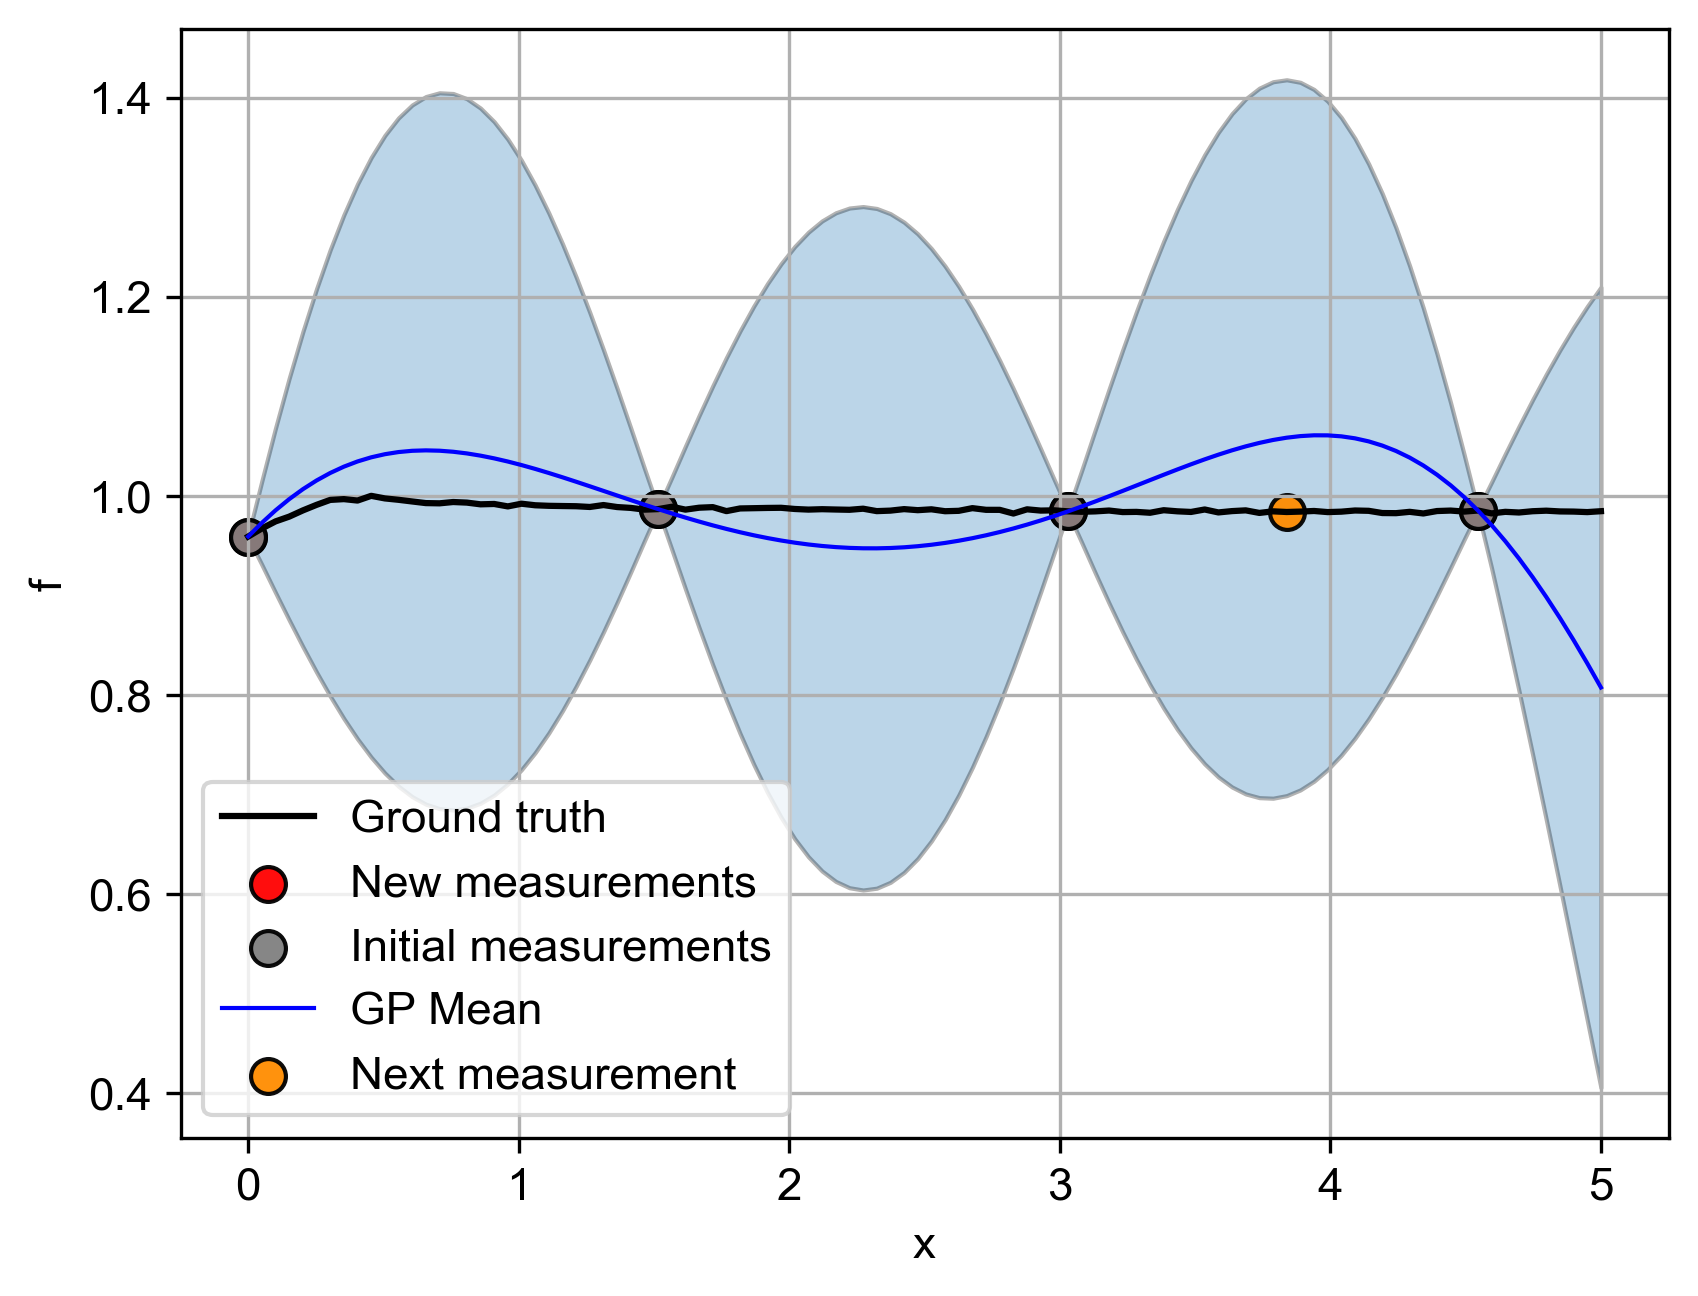

Iteration 2
New data point: [0.70707071] 0.9924700576042704


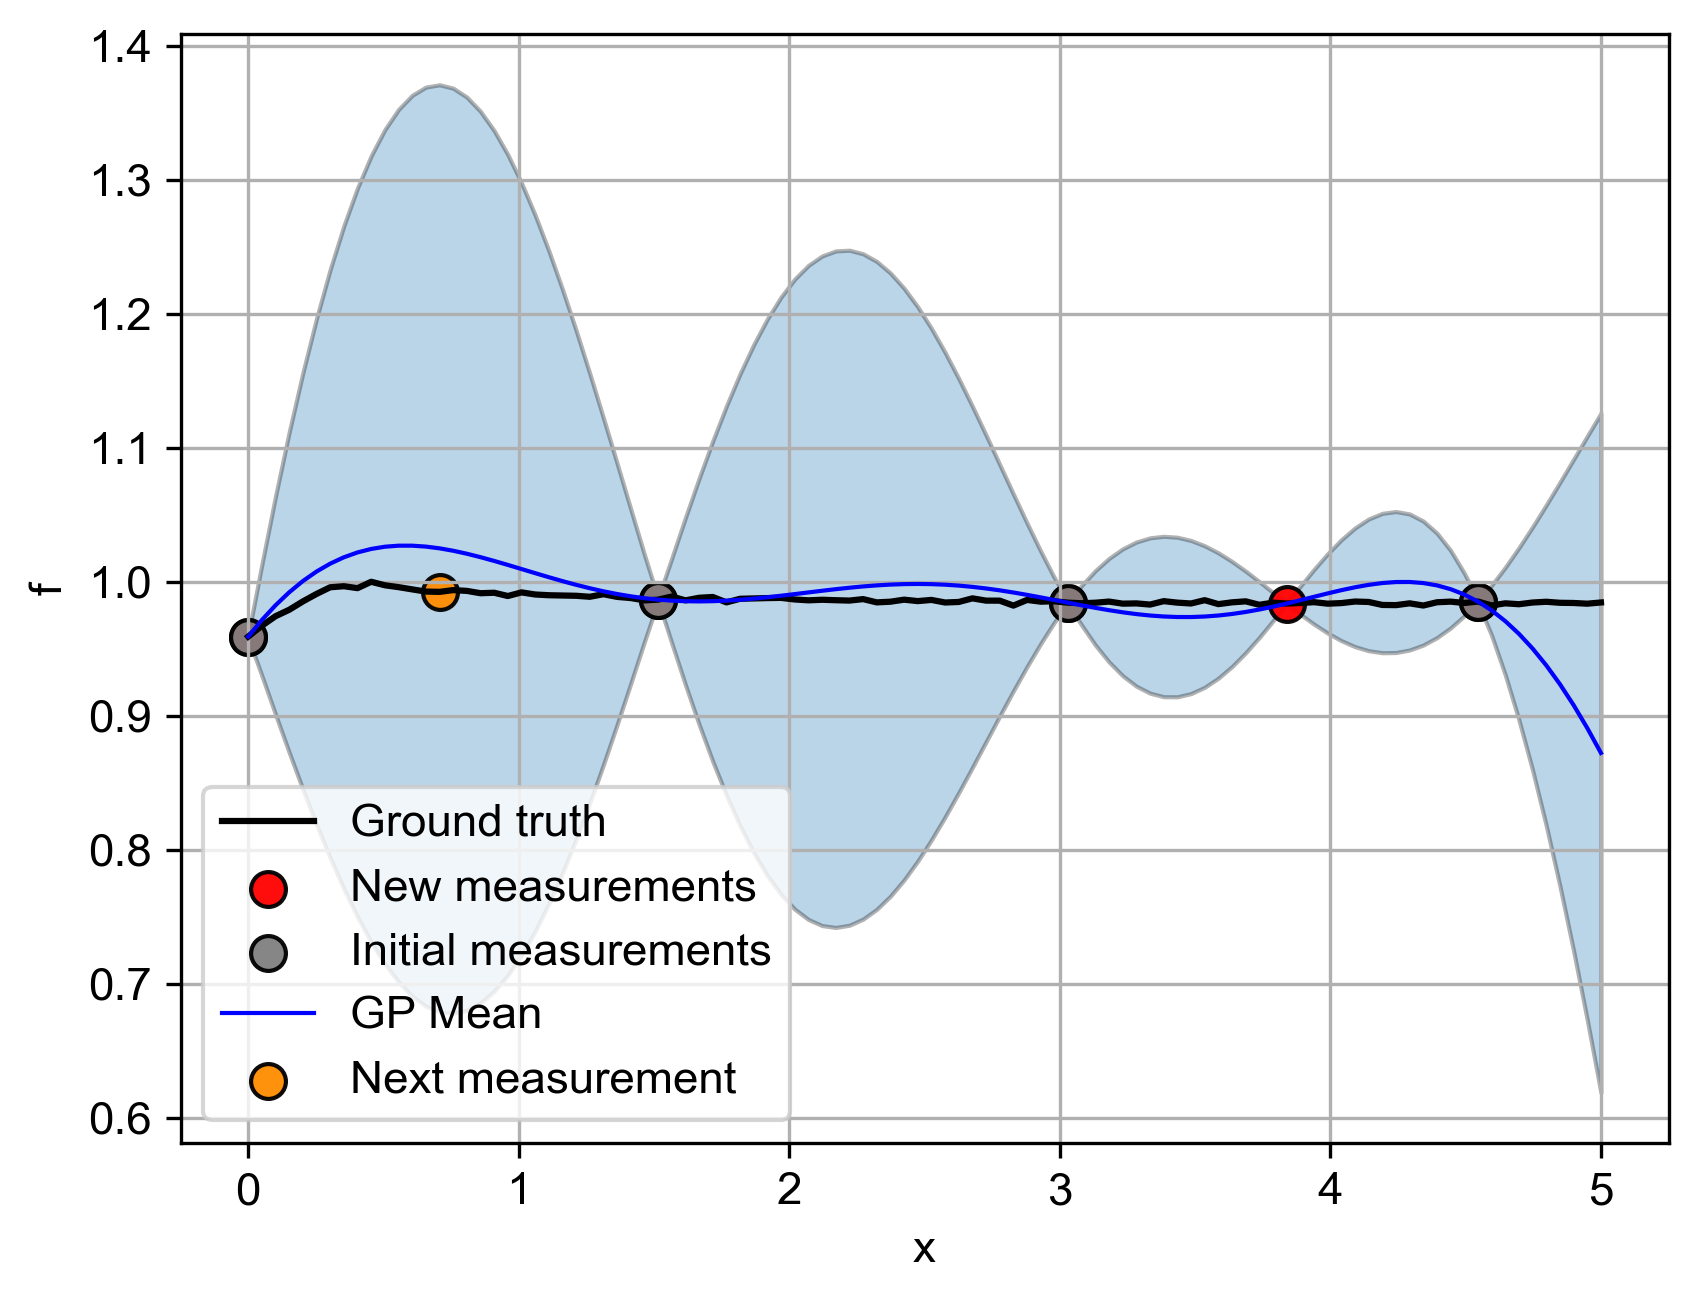

Iteration 3
New data point: [2.27272727] 0.9870786453928909


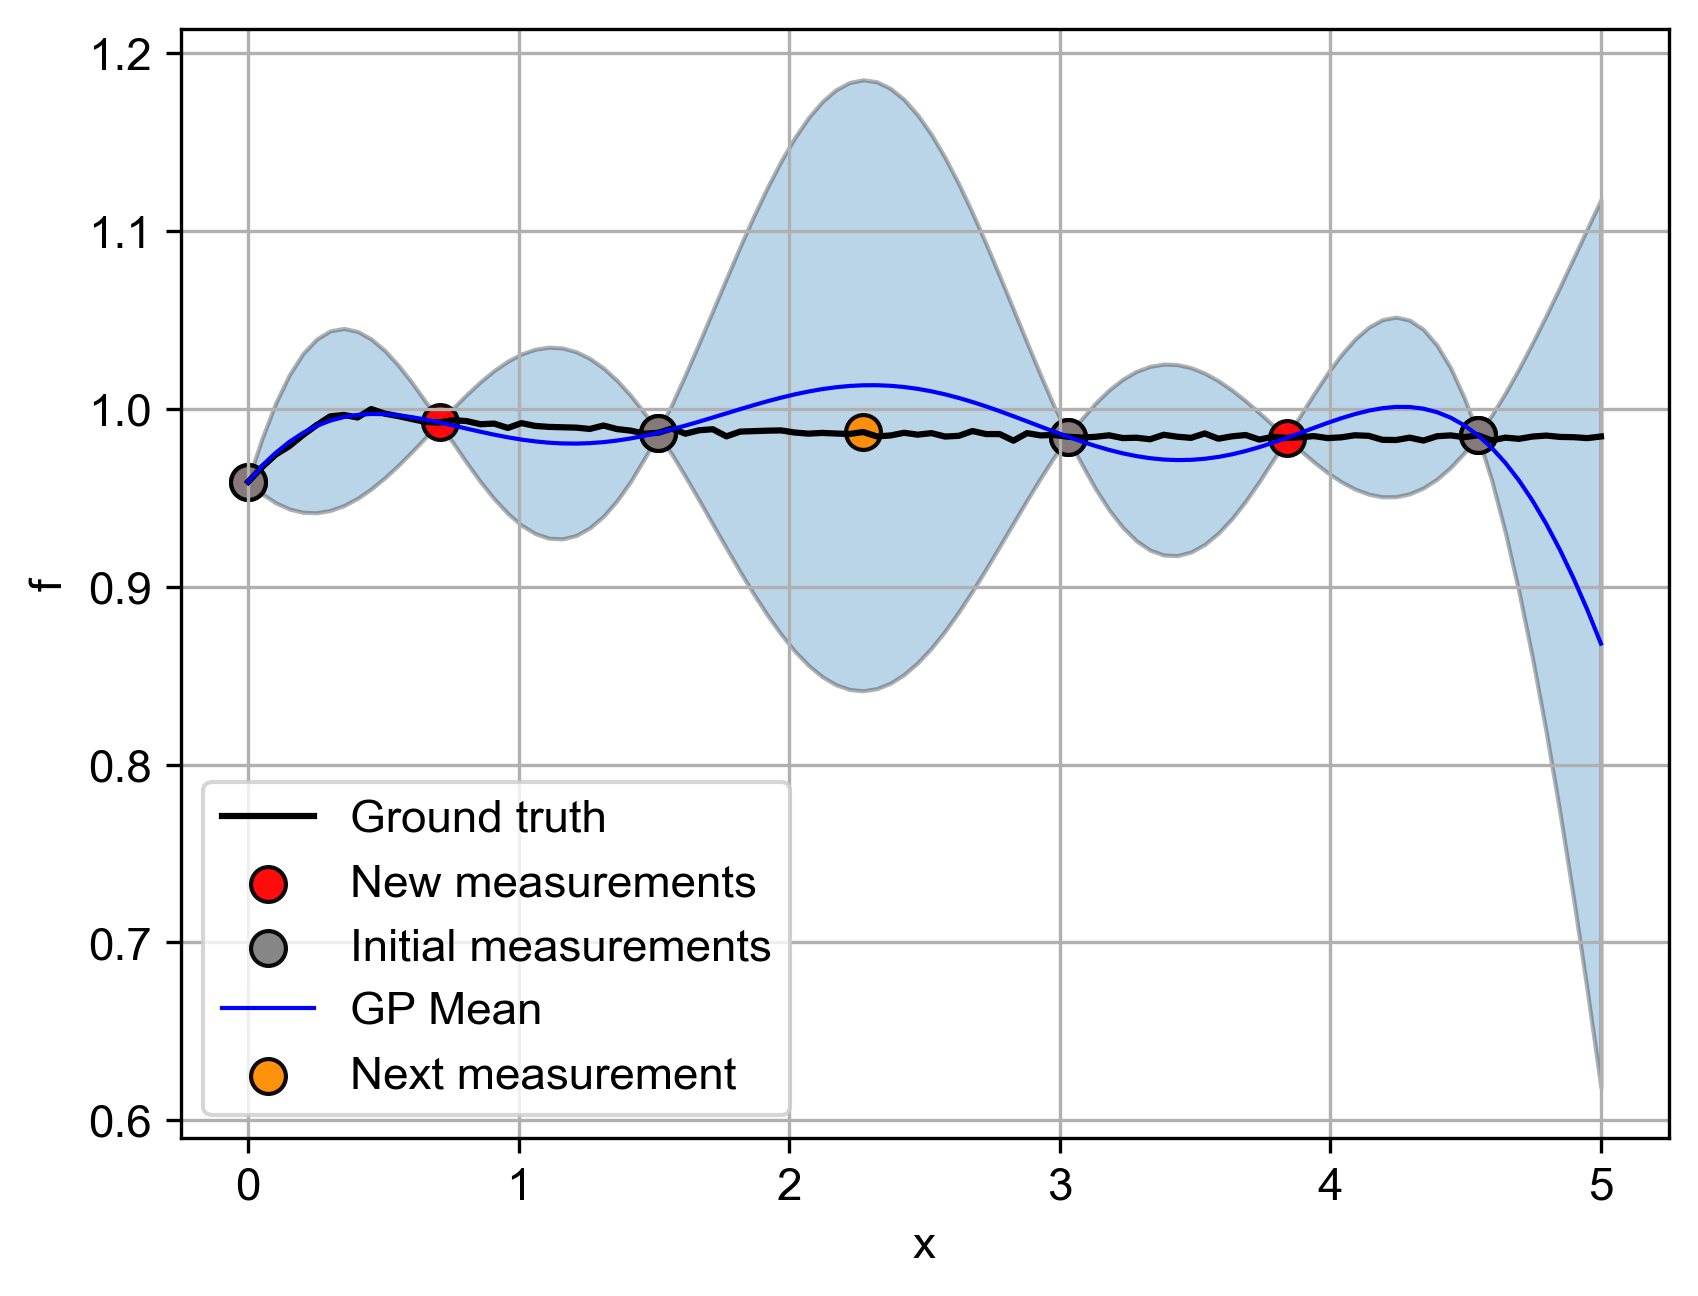

Iteration 4
New data point: [5.] 0.9845643151209102


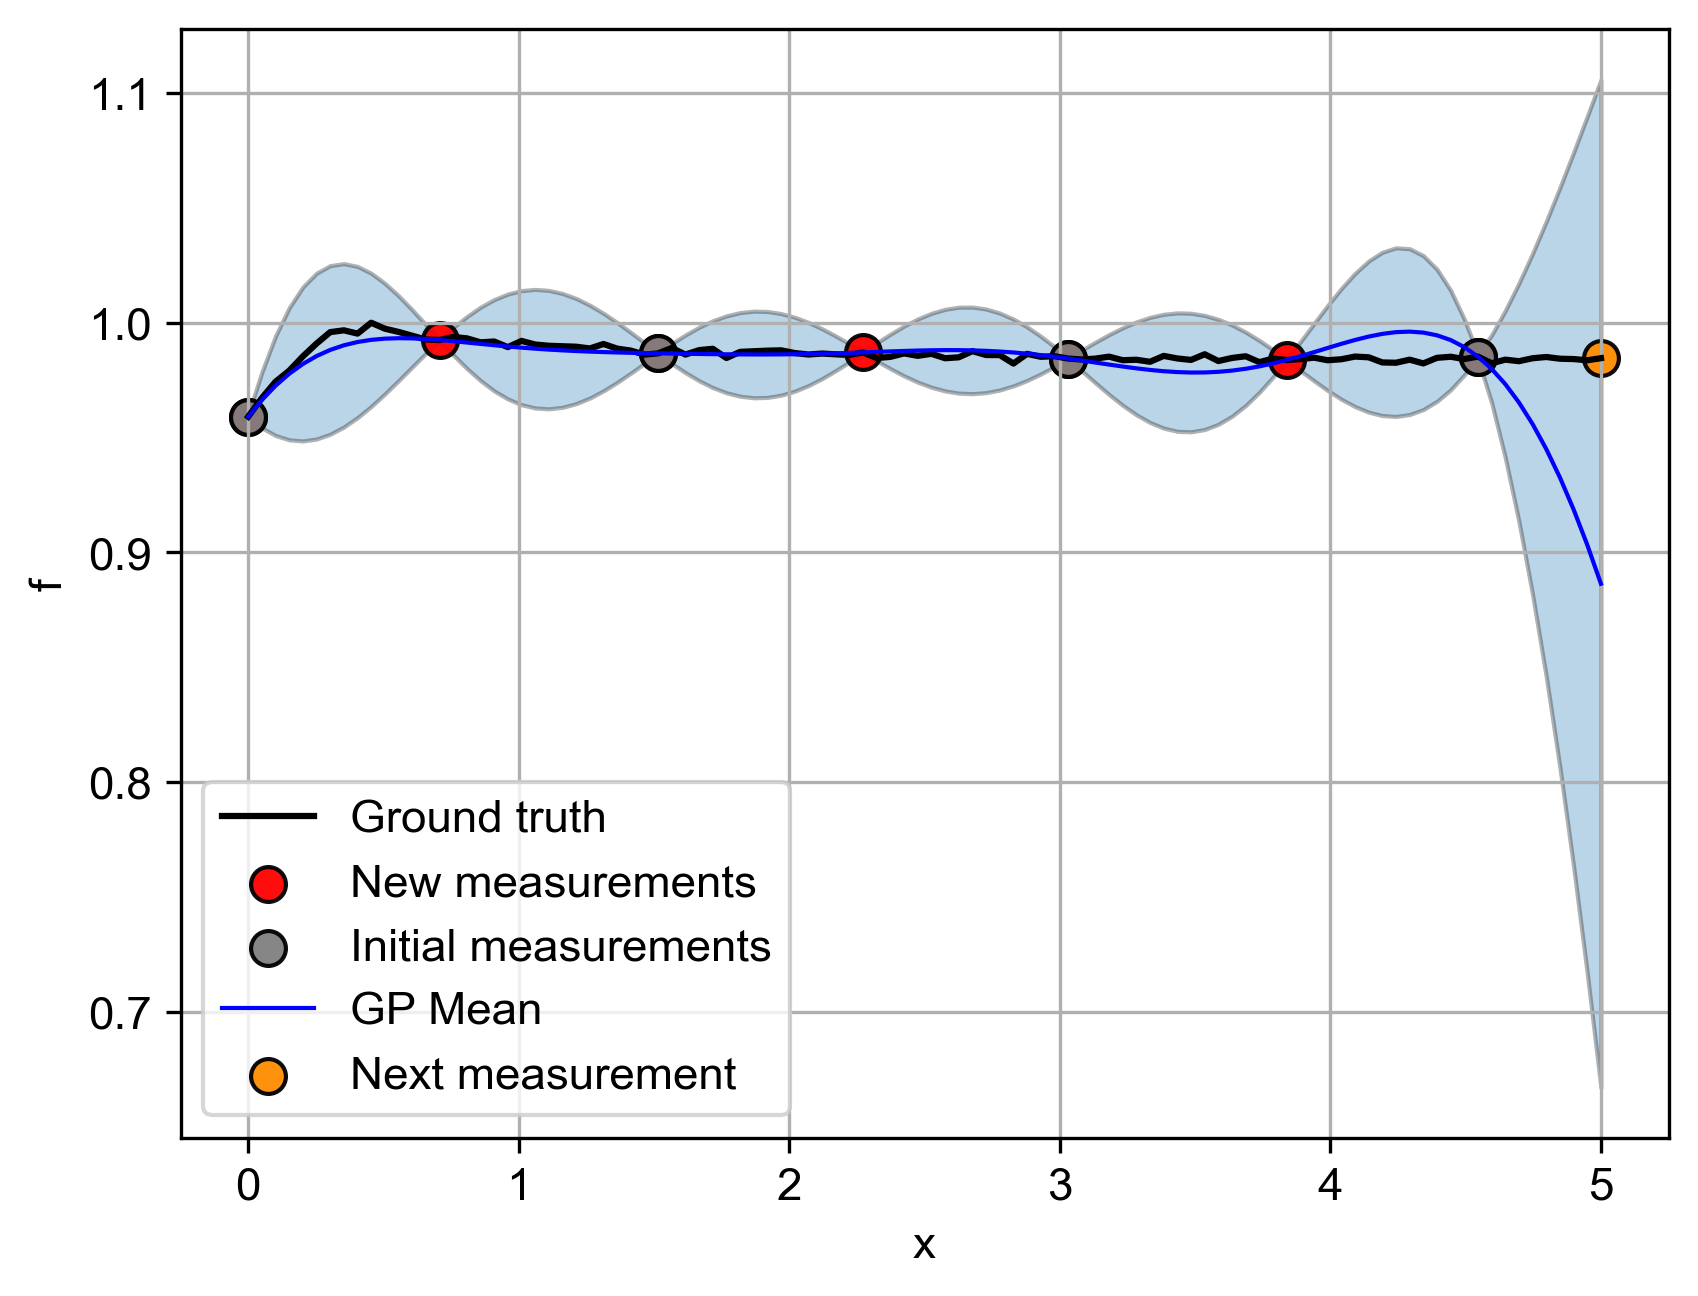

Iteration 5
New data point: [0.35353535] 0.9967003558356624


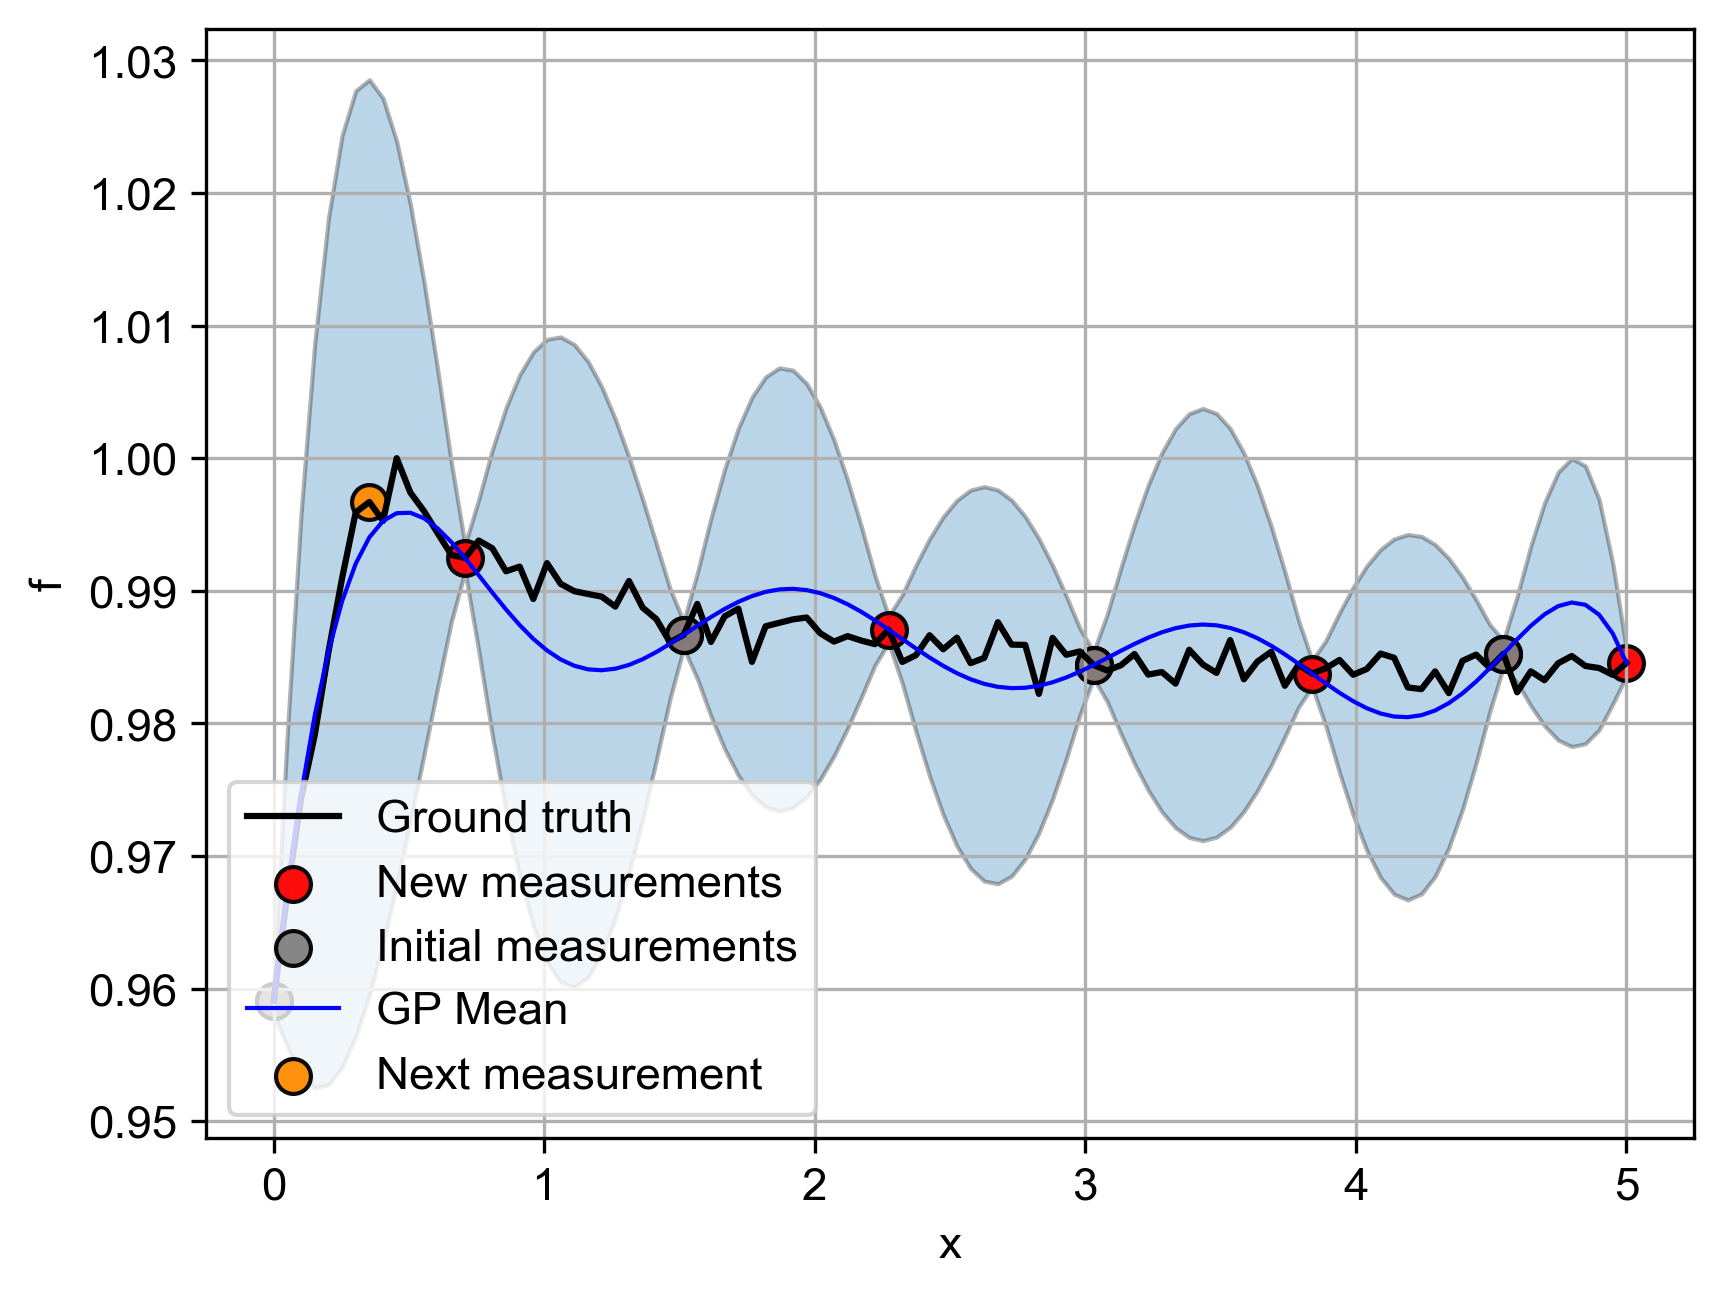

Iteration 6
New data point: [3.43434343] 0.9844392097285658


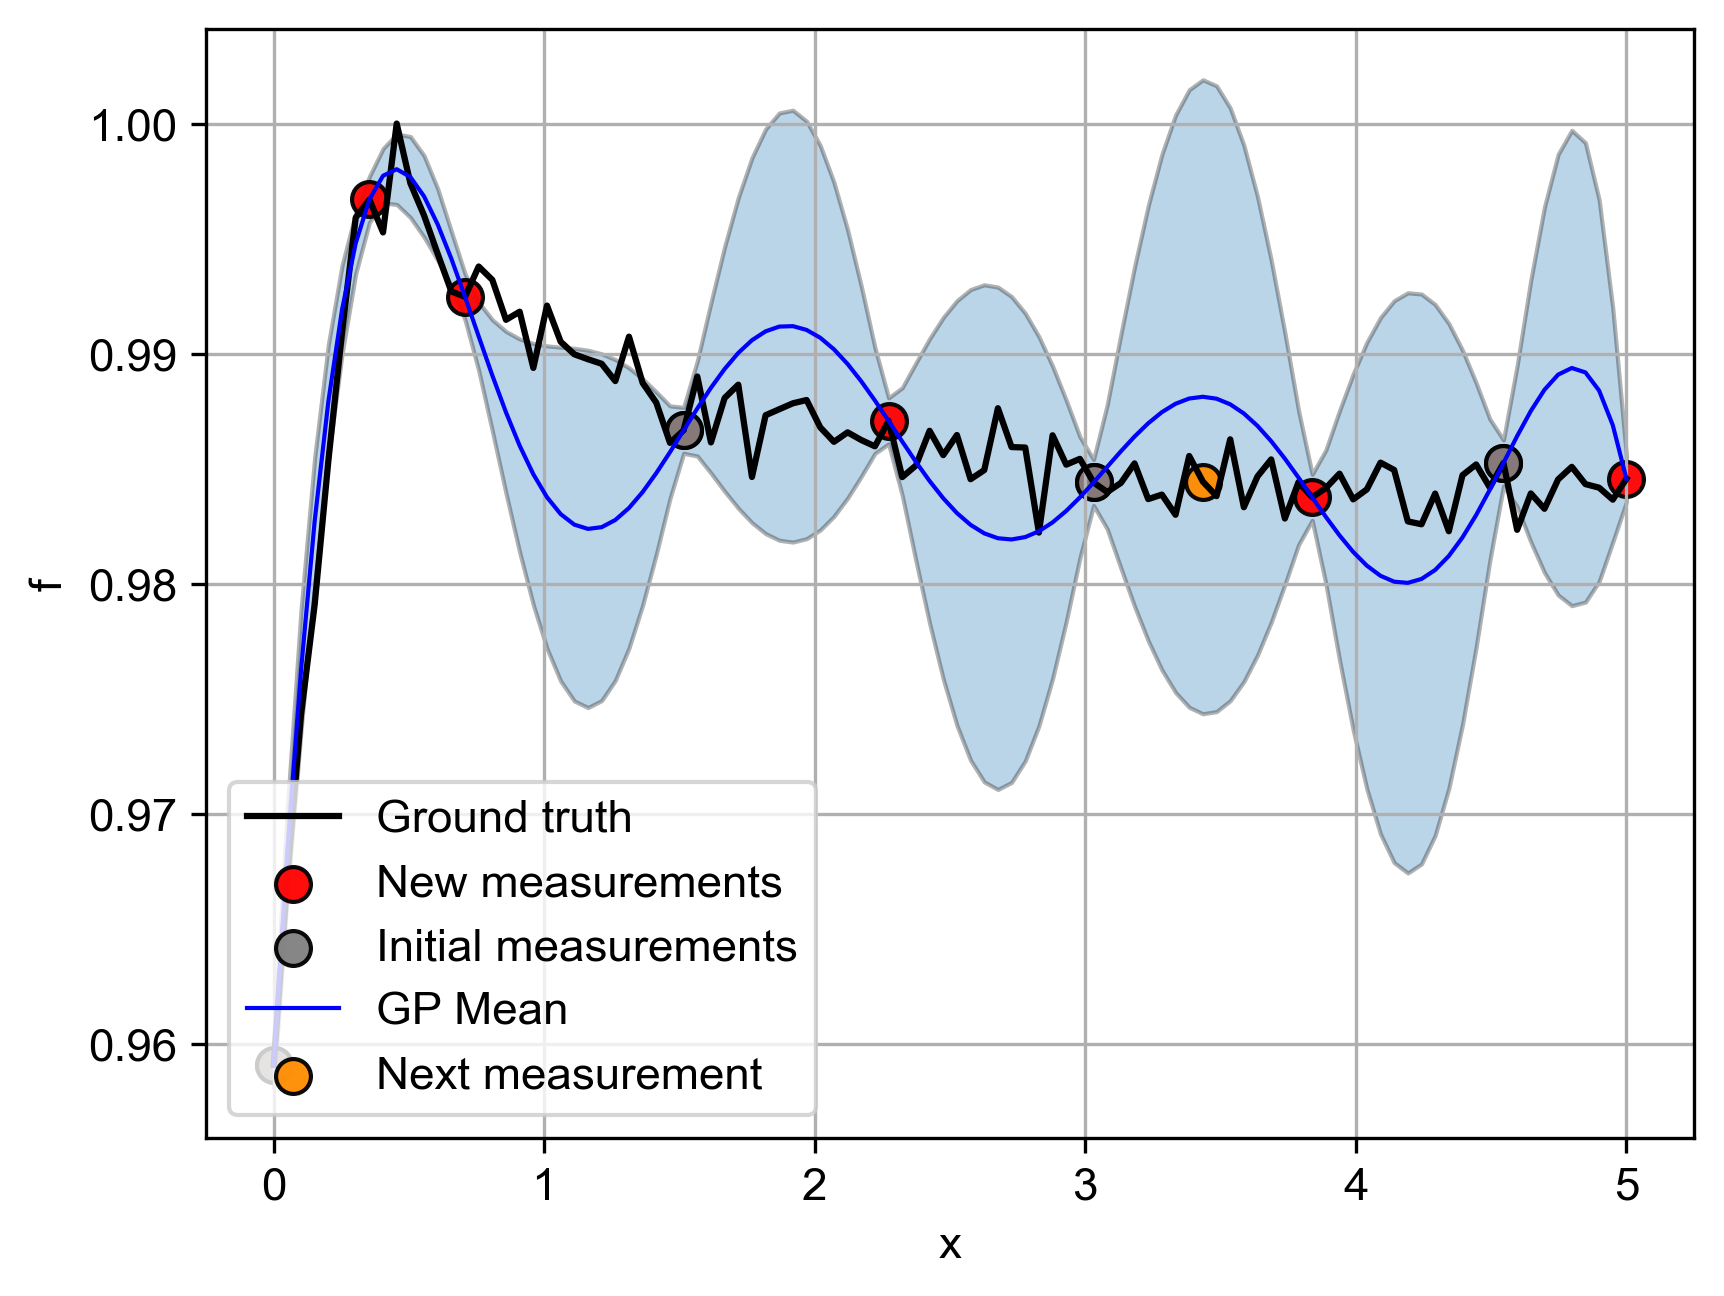

Iteration 7
New data point: [0.45454545] 1.0


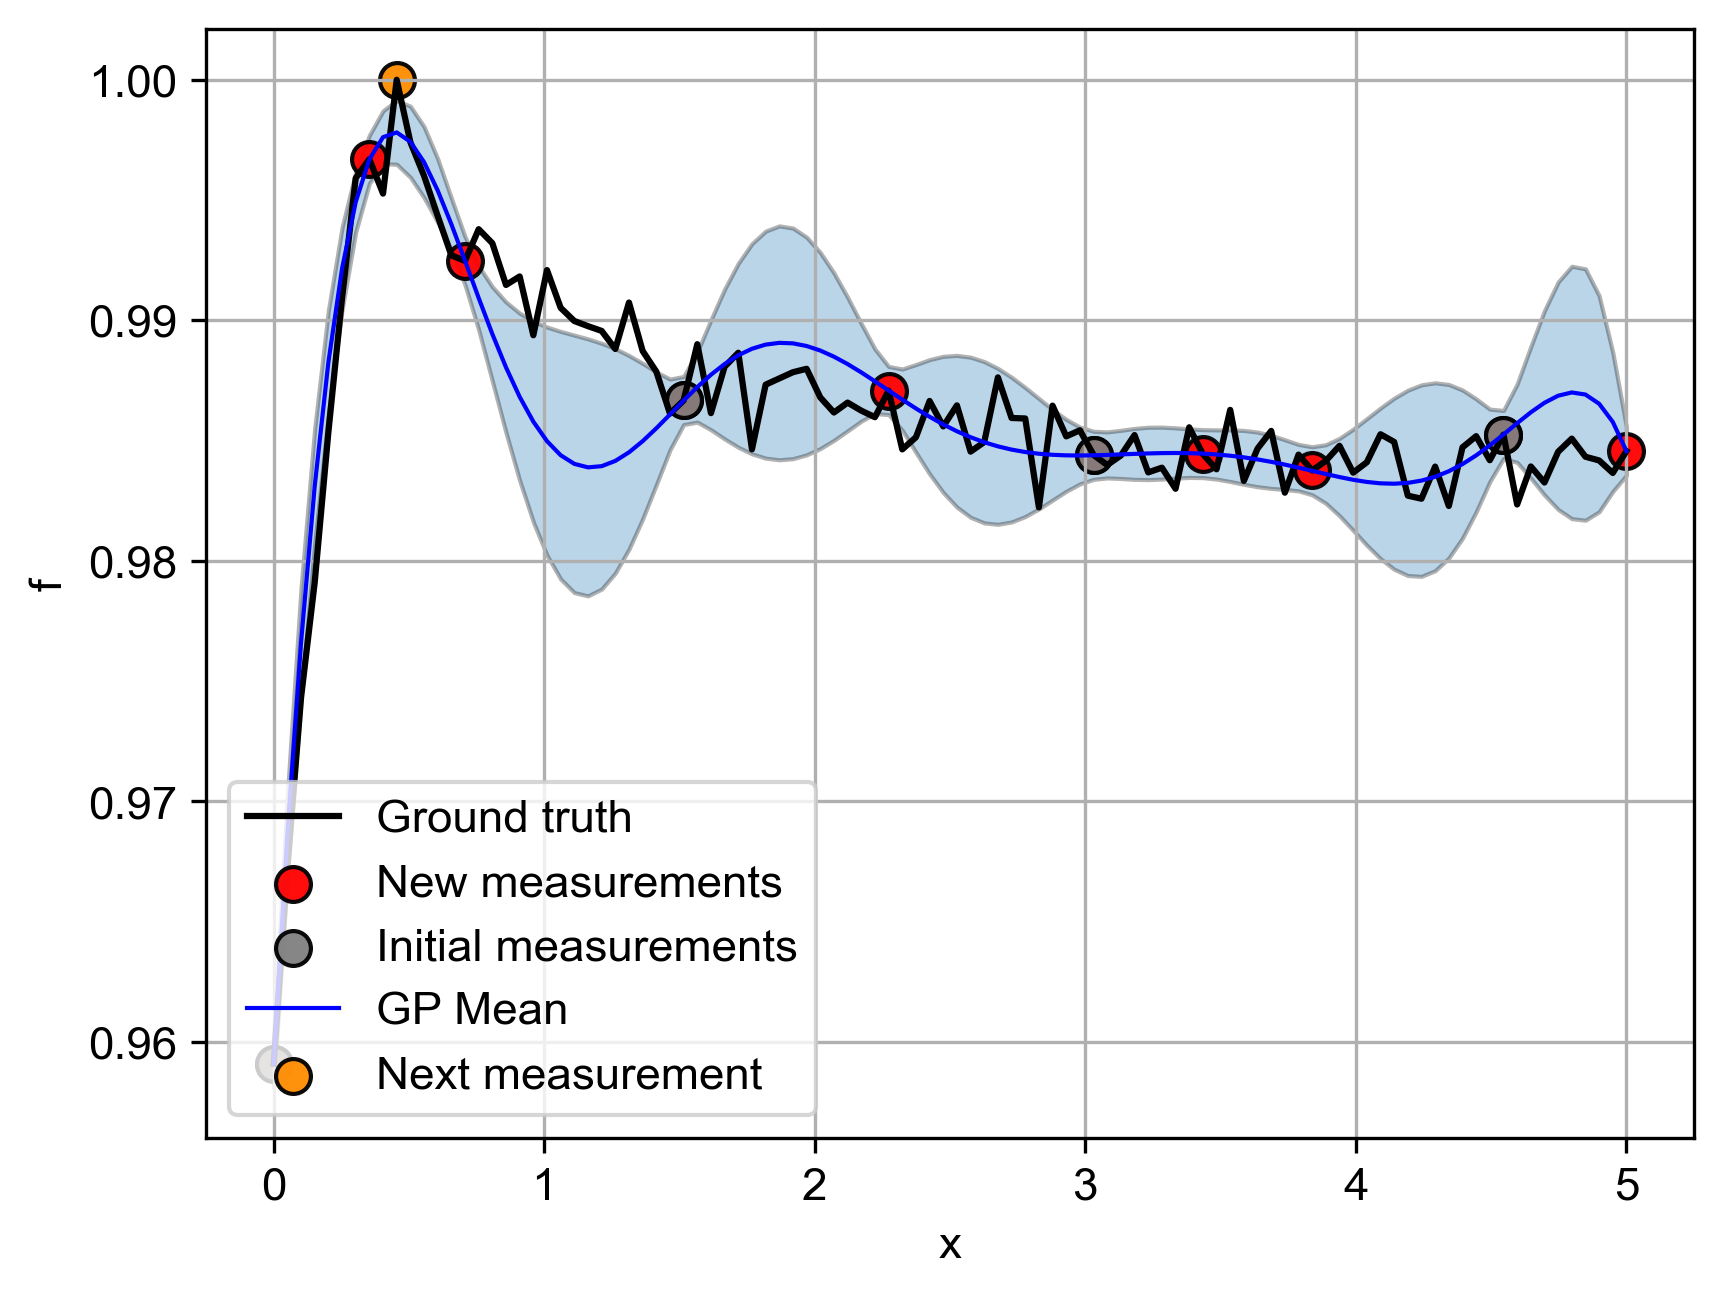

Iteration 8


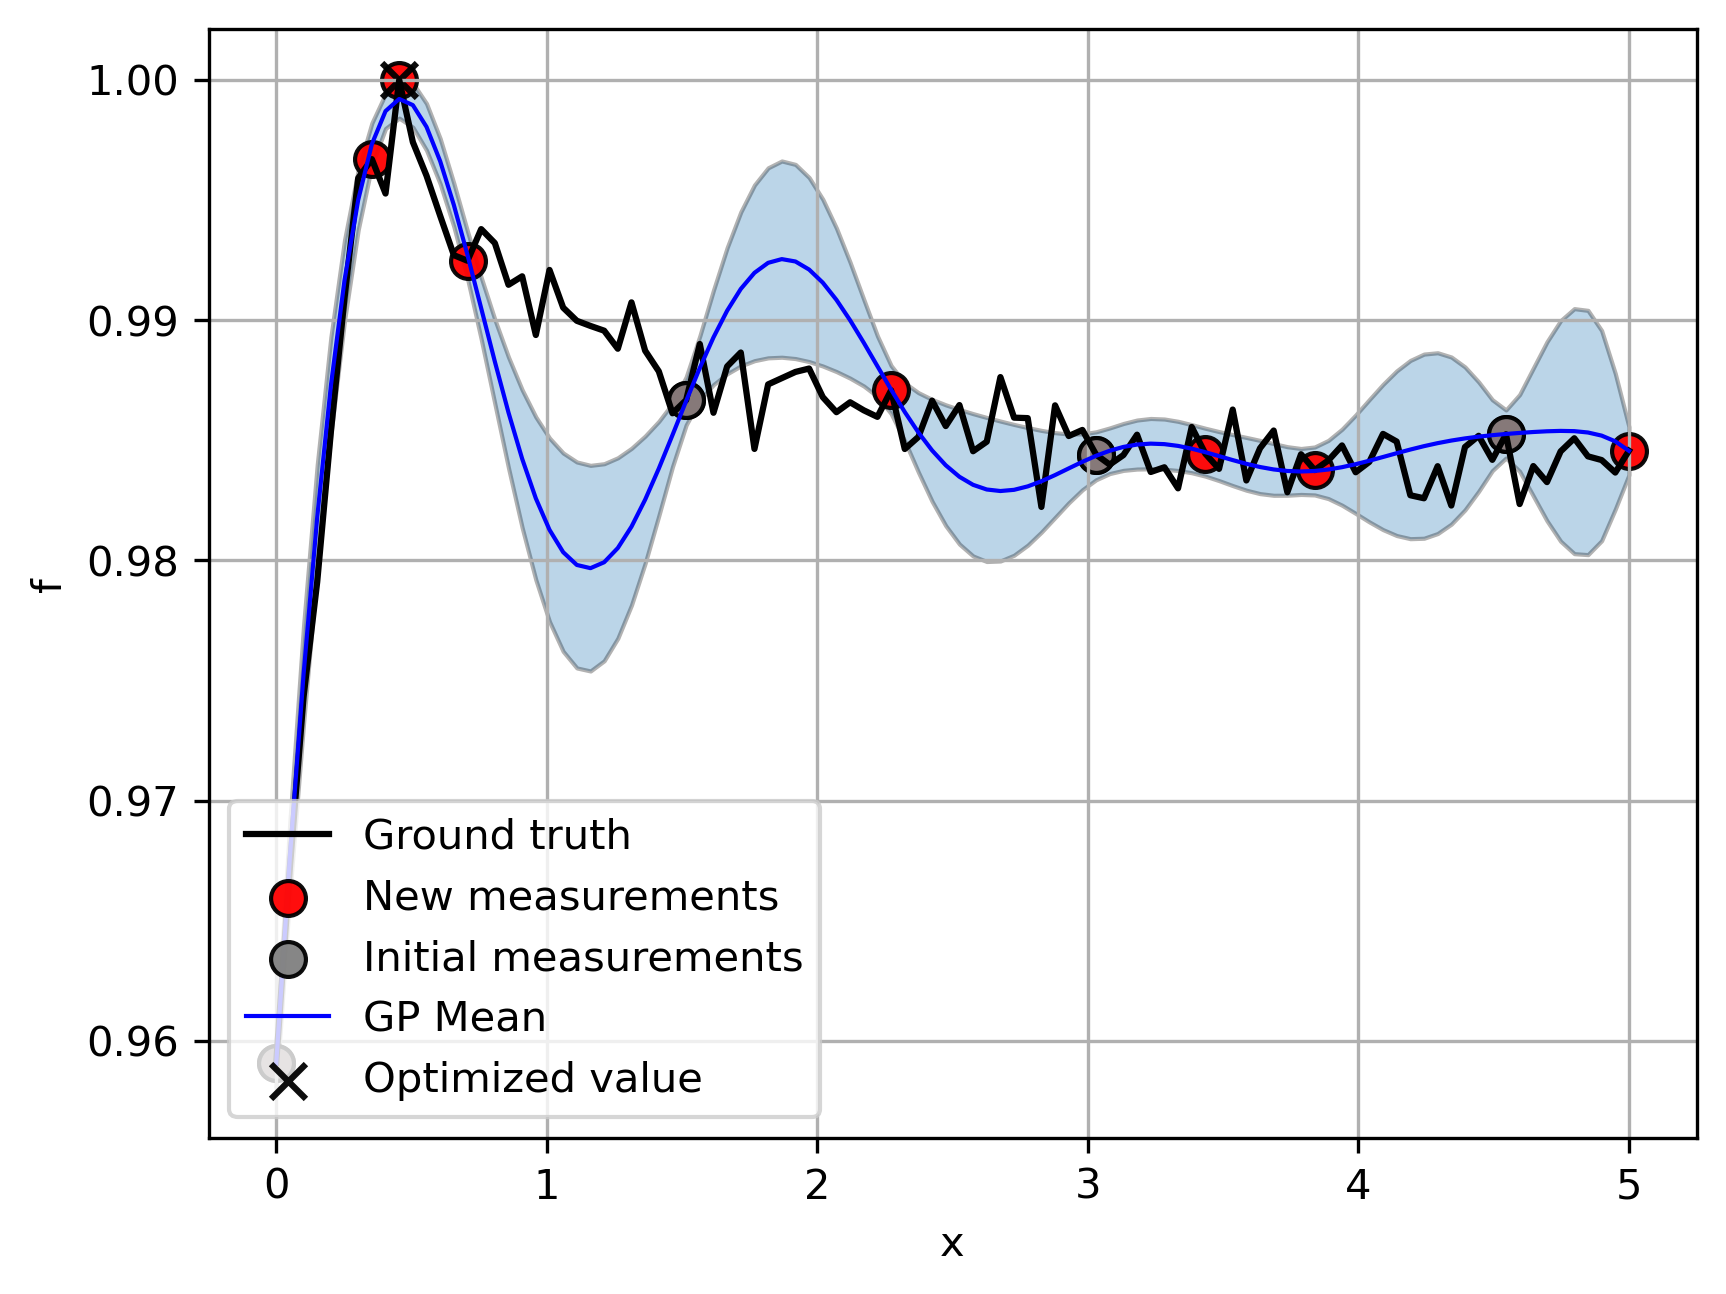

Convergence in step 8


In [12]:
init_meas_1=np.arange(0,99,30)
#init_meas_1=[0,5,12,20,60,90]
gaussian_opt(index_target_k=[9],num_iterations=20,simulated_k=k_angle_input_1_rescale, results_simulated_k=angle_distribution_all,indices_initial_k=init_meas_1,a=1,b=1)

In [13]:
init_meas_1

array([ 0, 30, 60, 90])

# Bayesian optimization using sklearn

## https://medium.com/@okanyenigun/step-by-step-guide-to-bayesian-optimization-a-python-based-approach-3558985c6818

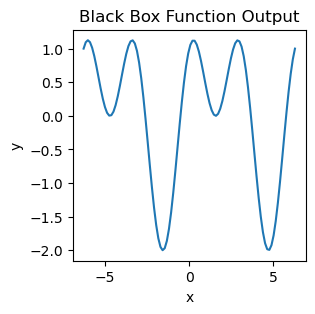

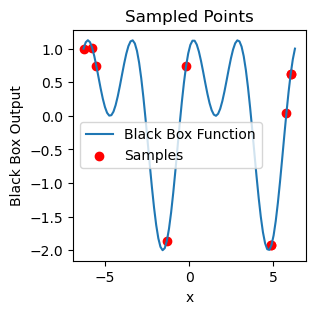

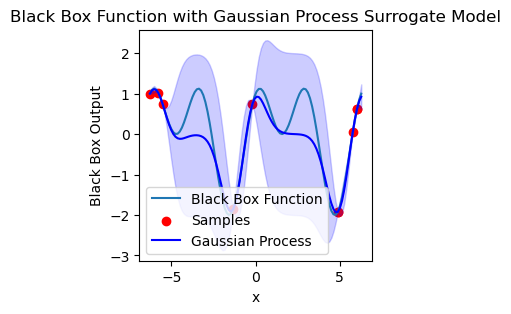

In [96]:
def black_box_function(x):
    y = np.sin(x) + np.cos(2*x)
    return y

# range of x values
x_range = np.linspace(-2*np.pi, 2*np.pi, 100)

# output for each x value
black_box_output = black_box_function(x_range)

# plot
plt.figure(figsize=(3,3))
plt.plot(x_range, black_box_output)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Black Box Function Output')
plt.show()

# random x values for sampling
num_samples = 10
sample_x = np.random.choice(x_range, size=num_samples)

# output for each sampled x value
sample_y = black_box_function(sample_x)

# plot
plt.figure(figsize=(3,3))
plt.plot(x_range, black_box_function(x_range), label='Black Box Function')
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Sampled Points')
plt.legend()
plt.show()

# Gaussian process regressor with an RBF kernel
kernel = RBF(length_scale=1.0)
gp_model = GaussianProcessRegressor(kernel=kernel)

# Fit the Gaussian process model to the sampled points
gp_model.fit(sample_x.reshape(-1, 1), sample_y)

# Generate predictions using the Gaussian process model
y_pred, y_std = gp_model.predict(x_range.reshape(-1, 1), return_std=True)

# Plot 
plt.figure(figsize=(3,3))
plt.plot(x_range, black_box_function(x_range), label='Black Box Function')
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.plot(x_range, y_pred, color='blue', label='Gaussian Process')
plt.fill_between(x_range, y_pred - 2*y_std, y_pred + 2*y_std, color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Black Box Function with Gaussian Process Surrogate Model')
plt.legend()
plt.show()

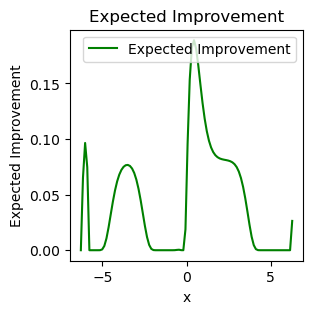

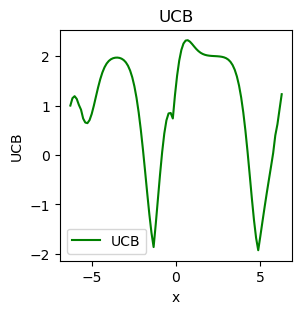

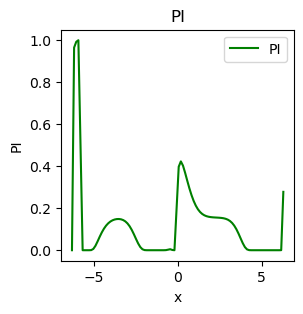

In [97]:
def expected_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

# Determine the point with the highest observed function value
best_idx = np.argmax(sample_y)
best_x = sample_x[best_idx]
best_y = sample_y[best_idx]

ei = expected_improvement(x_range, gp_model, best_y)

# Plot the expected improvement
plt.figure(figsize=(3,3))
plt.plot(x_range, ei, color='green', label='Expected Improvement')
plt.xlabel('x')
plt.ylabel('Expected Improvement')
plt.title('Expected Improvement')
plt.legend()
plt.show()
def upper_confidence_bound(x, gp_model, beta):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    ucb = y_pred + beta * y_std
    return ucb

beta = 2.0

# UCB
ucb = upper_confidence_bound(x_range, gp_model, beta)

plt.figure(figsize=(3,3))
plt.plot(x_range, ucb, color='green', label='UCB')
plt.xlabel('x')
plt.ylabel('UCB')
plt.title('UCB')
plt.legend()
plt.show()

def probability_of_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    pi = norm.cdf(z)
    return pi

# Probability of Improvement
pi = probability_of_improvement(x_range, gp_model, best_y)


plt.figure(figsize=(3,3))
plt.plot(x_range, pi, color='green', label='PI')
plt.xlabel('x')
plt.ylabel('PI')
plt.title('PI')
plt.legend()
plt.show()

<Figure size 300x300 with 0 Axes>

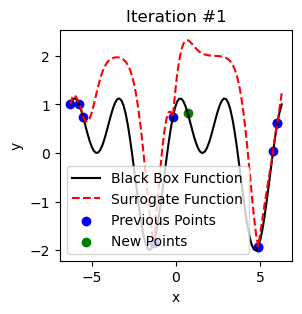

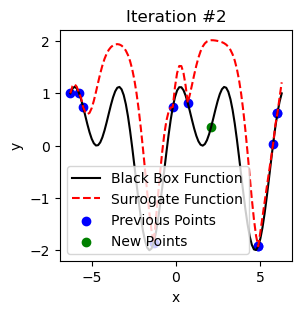

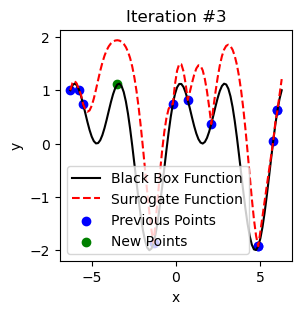

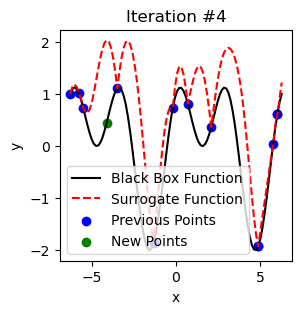

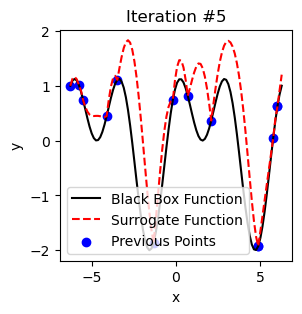

In [98]:
num_iterations = 5

plt.figure(figsize=(3,3))

for i in range(num_iterations):
    # Fit the Gaussian process model to the sampled points
    gp_model.fit(sample_x.reshape(-1, 1), sample_y)

    # Determine the point with the highest observed function value
    best_idx = np.argmax(sample_y)
    best_x = sample_x[best_idx]
    best_y = sample_y[best_idx]

    # Set the value of beta for the UCB acquisition function
    beta = 2.0

    # Generate the Upper Confidence Bound (UCB) using the Gaussian process model
    ucb = upper_confidence_bound(x_range, gp_model, beta)

    # Plot the black box function, surrogate function, previous points, and new points
    plt.figure(figsize=(3,3))
    plt.plot(x_range, black_box_function(x_range), color='black', label='Black Box Function')
    plt.plot(x_range, ucb, color='red', linestyle='dashed', label='Surrogate Function')
    plt.scatter(sample_x, sample_y, color='blue', label='Previous Points')
    if i < num_iterations - 1:
        new_x = x_range[np.argmax(ucb)]  # Select the next point based on UCB
        new_y = black_box_function(new_x)
        sample_x = np.append(sample_x, new_x)
        sample_y = np.append(sample_y, new_y)
        plt.scatter(new_x, new_y, color='green', label='New Points')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Iteration #{i+1}")
    plt.legend()
    plt.show()

In [105]:
#select target distribution

def gaussian_opt_skl(index_target_k,num_iterations,simulated_k, results_simulated_k, indices_initial_k,a=1,b=1):
    #run gaussian opt. for every target in index_target_k
    
    for i in range(len(index_target_k)):
        #get ground truth for indexed k
        target_result=results_simulated_k[index_target_k[i]]
        #calculate the difference between the result of target k (mean, std or full distribution) and the results from all k values
        
        deviation=[]
        for j in range(len(results_simulated_k)):
            deviation.append(np.sum(np.abs(target_result-results_simulated_k[j])) ) #k values, zero for target k
        deviation=np.asarray(deviation)
        #get function to optimize
        ground_truth_1=1/(deviation+1)
        #ground_truth_1=gaussian_filter(ground_truth_1,sigma=1)
        #gd_scaler=MinMaxScaler(feature_range=(-10, 10))
        #ground_truth_1=gd_scaler.fit_transform(ground_truth_1.reshape(-1, 1)).flatten() 
        '''plt.figure()
        plt.errorbar(np.arange(0,len(ground_truth)),ground_truth)
        plt.xlabel("k")
        plt.ylabel("f")
        plt.grid()
        plt.show()'''
        
        #get x values for prediction after fitting
        #n = 200
        x = simulated_k.reshape(-1, 1)  #np.linspace(0, 1, n).reshape(-1, 1)
        
        #append initial training data
        data_x=[]
        data_f=[]
        data_x_init=[]
        data_f_init=[]
        for s in indices_initial_k:
            data_x.append(simulated_k[s])
            data_f.append(ground_truth_1[s])
            data_x_init.append(simulated_k[s])
            data_f_init.append(ground_truth_1[s])
        data_x=np.asarray(data_x)
        data_f=np.asarray(data_f)
        conver1=False
        for m in range(num_iterations):
            print("Iteration",m+1)
            if m>1 and f_next==1:
                conver1=True    
            # fitting the initial GP model
            kernel = RBF(length_scale=0.04) #+ WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1e1))
            gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
            gp_model.fit(data_x.reshape(-1, 1), data_f.reshape(-1, 1))
            mu, uncertainty = gp_model.predict(x, return_std=True)
            print(gp_model.kernel_)

            # plotting the data and the GP model
            plt.figure()
            plt.plot(x, ground_truth_1, "k-", label = "Ground truth")
            plt.scatter(data_x, data_f, marker = "o", s = 70.0, edgecolor="k", facecolor="b", alpha = 0.95, label = "New measurements")
            plt.scatter(data_x_init, data_f_init, marker = "o", s = 70.0, edgecolor="k", facecolor="r", alpha = 0.95, label = "Initial measurements")
  
            plt.plot(x.ravel(), mu, label = 'GP Mean', linewidth = 1, color = "b")
            plt.fill_between(x.ravel(), mu + uncertainty, mu - uncertainty, alpha = 0.3, edgecolor = "k", zorder = 0)
            plt.xlabel("x")
            plt.ylabel("f")
            #plt.xlim([0, 5])
            #plt.ylim([0, 3])
            
            
            #update model with new data point
            beta=1
            #ac  = upper_confidence_bound(x_range, gp_model, beta)
            #ac=probability_of_improvement(x_range, gp_model, beta)
            ac=expected_improvement(x_range, gp_model, beta)
            
            x_next = x[np.argmax(ac)]
            f_next = ground_truth_1[np.argmax(ac)]
            print("New data point:",x_next,f_next)
            #append new data and update model fit
            data_x = np.append(data_x, x_next)
            data_f = np.append(data_f, f_next)
            
            plt.scatter(x_next, f_next, marker = "o", s = 70.0, edgecolor="k", facecolor="g", alpha = 0.95, label = "Next measurement")
            plt.legend(loc="lower left")
            plt.grid()
            plt.show()
            
            if conver1==True:
                print("Convergence in step",m+1)
                break
        
    

Iteration 1
RBF(length_scale=7.08)
New data point: [5.] 0.9845643151209102


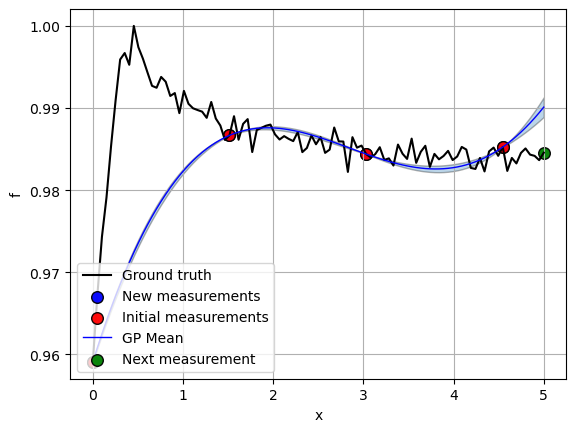

Iteration 2
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


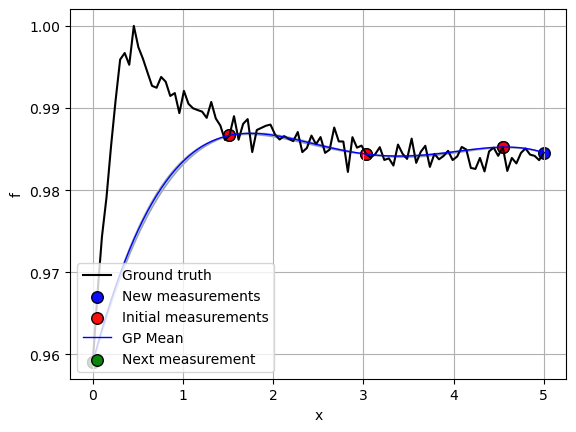

Iteration 3
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


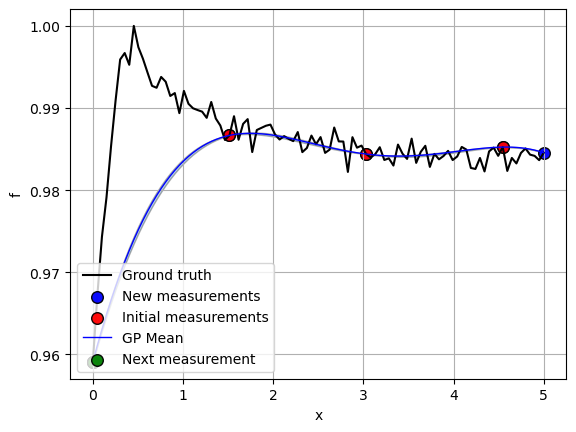

Iteration 4
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


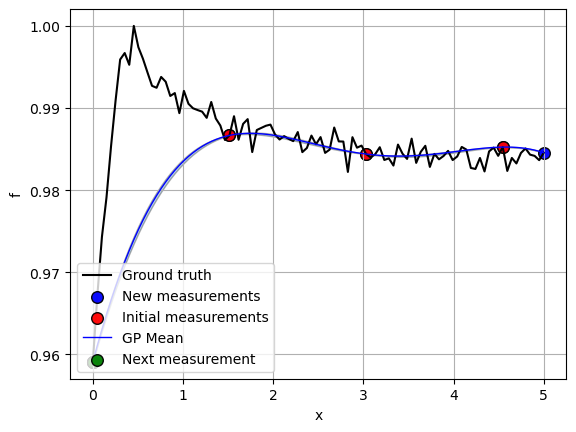

Iteration 5
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


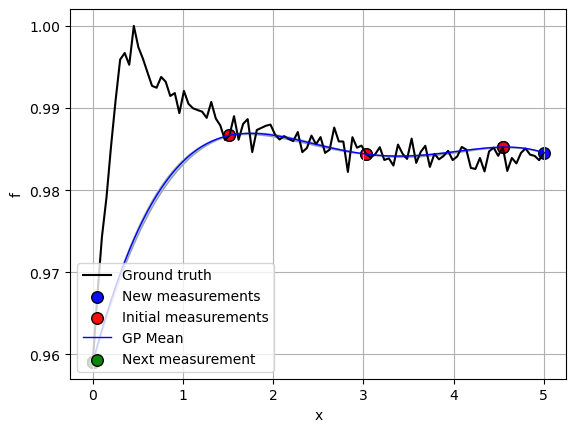

Iteration 6
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


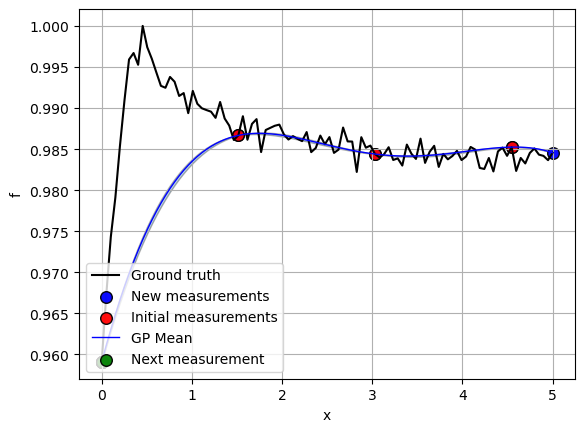

Iteration 7
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


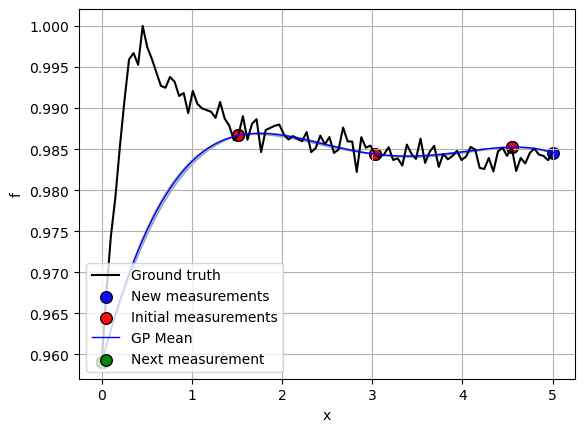

Iteration 8
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


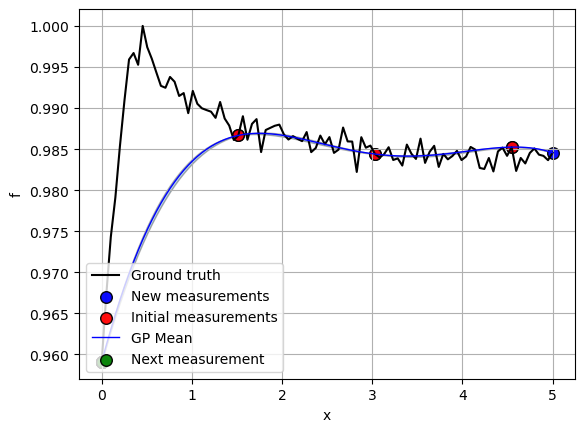

Iteration 9
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


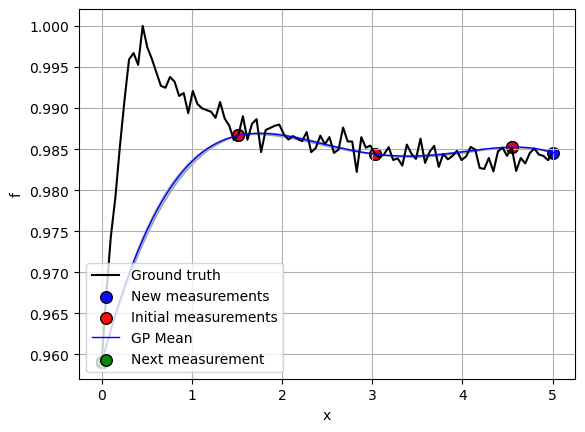

Iteration 10
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


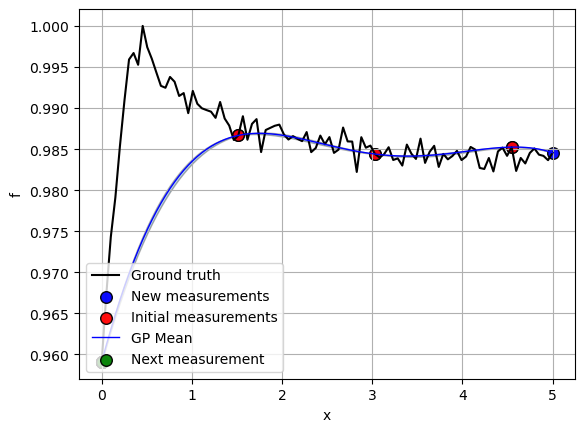

Iteration 11
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


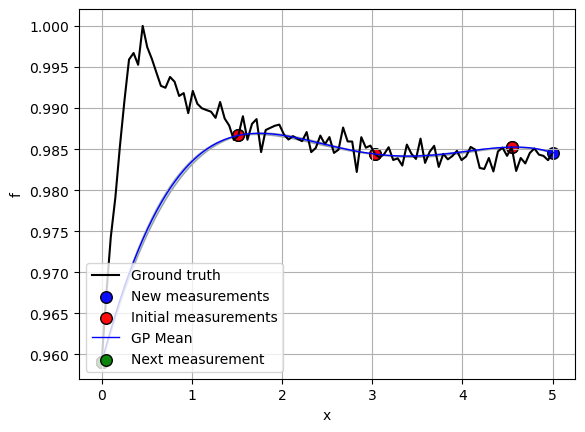

Iteration 12
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


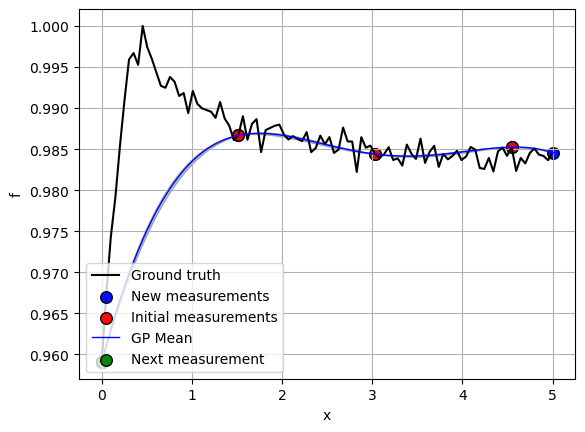

Iteration 13
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


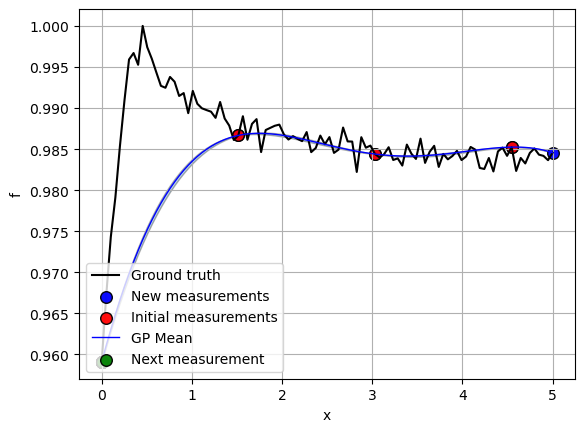

Iteration 14
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


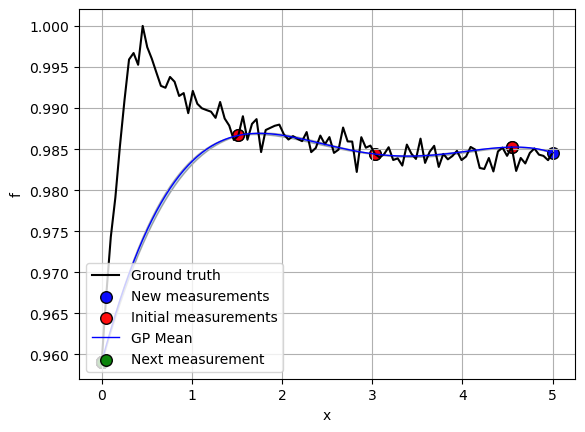

Iteration 15
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


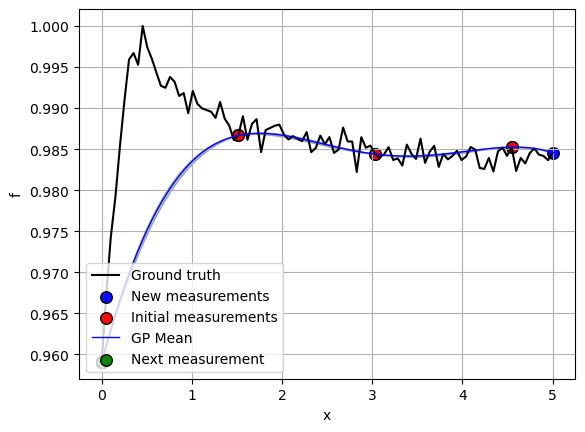

Iteration 16
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


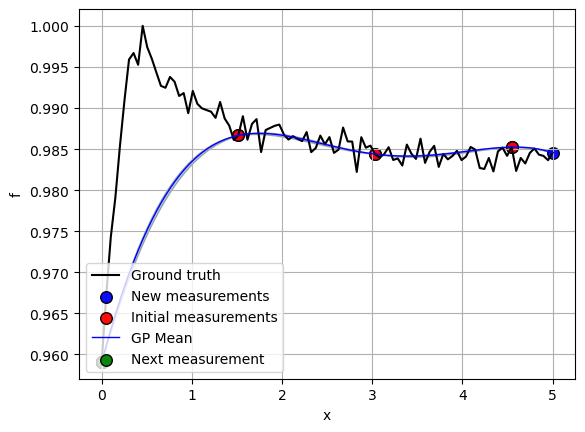

Iteration 17
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


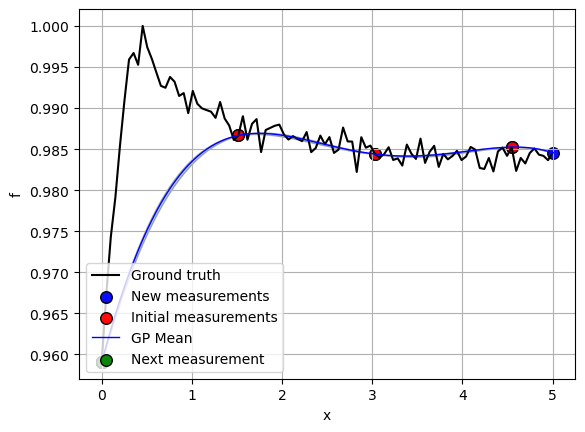

Iteration 18
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


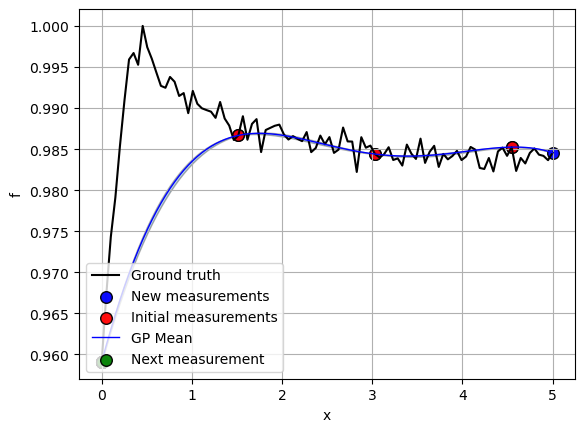

Iteration 19
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


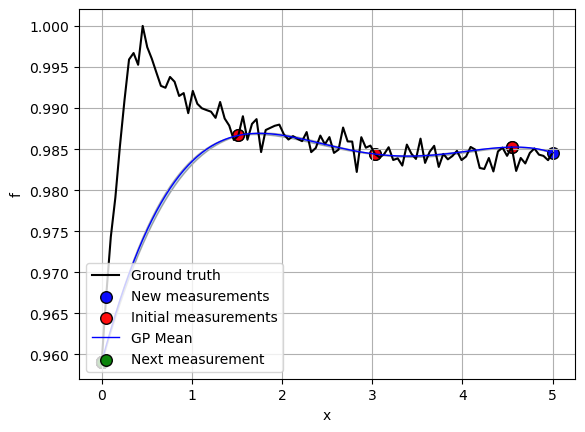

Iteration 20
RBF(length_scale=5.39)
New data point: [0.] 0.9590957755790842


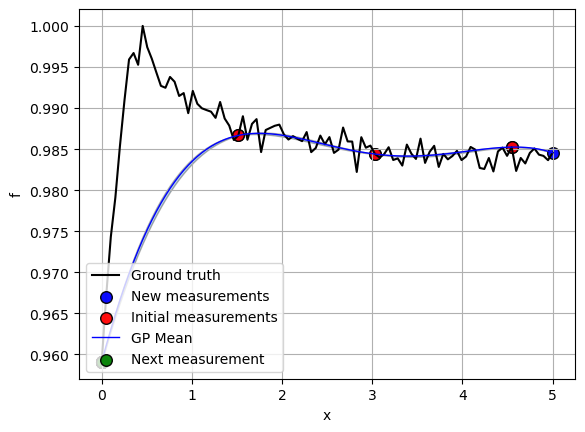

In [106]:
init_meas_1=np.arange(0,99,30)
#init_meas_1=[0,5,12,20,60,90]
gaussian_opt_skl(index_target_k=[9],num_iterations=20,simulated_k=k_angle_input_1_rescale, results_simulated_k=angle_distribution_all,indices_initial_k=init_meas_1,a=1,b=1)